# 台股加權指數預測
##### 以機器學習模型根據各種財經指數預測明天的台股加權指數漲跌幅

環境準備
========
1. 本程式使用到TA-Lib函式庫，在windows環境下執行前須先下載安裝C++ Builder編譯器：
   https://www.microsoft.com/en-us/download/details.aspx?id=48159
2. 在 https://github.com/mrjbq7/ta-lib 下載ta-lib，解壓到C:\ta-lib   
3. 打開【開始選單】》【Microsoft Visual C++ Compiler Package for Python 2.7】》【Visual C++ 2008 64-bit Command Prompt】
   cd C:\ta-lib\c\make\cdr\win32\msvc 然後再輸入執行 nmake
4. 安裝TA-Lib函式庫:
   pip install TA-Lib
5. ~~安裝tushare函式庫:
   pip install tushare~~
6. 安裝matplotlib.finance函式庫:
   pip install mpl_finance
7. 安裝fix_yahoo_finance數據下載函式庫:
   pip install fix_yahoo_finance
8. 安裝機器學習Sickit Learn函式庫:
   pip install sklearn
8. 安裝機器學習Boruta特徵篩選函式庫:
   pip install Boruta

資料擷取
====
1. 從Yahoo Finance擷取財經資料，短時間內不可重複抓取。
2. 將收盤價與成交量資料轉為漲跌幅

參數清單
--------
1.	台股指數-^TWII
2.	道瓊工業指數-^DJI
3.	標準普爾指數S&P 500-^GSPC
4.	那斯達克指數-^IXIC
5.	費城半導體指數-^SOX
6.	紐約交易所指數-^NYA
7.	芝加哥交易所指數-^VIX 
8.	歐洲市場指數-VGK
9.	全球股市指數-VT
10.	上證指數-000001.SS
11.	深圳指數-399001.SZ
12.	日經指數-^N225
13.	中國大型股-FXI
14.	美國債券-BND
15.	美國10年國債-IEF
16.	美國3年國債-SHY
17.	美國20年國債-TLT
18.	原油價格-CL=F
19.	黃金價格-GC=F
20.	台幣兌美元匯率-TWD=X

In [44]:
import pandas as pd
#from pandas_datareader import data    <--for fix ImportError: cannot import name 'is_list_like'
#pd.core.common.is_list_like = pd.api.types.is_list_like
#from pandas_datareader import data
import fix_yahoo_finance as yf
import datetime

#抓取從2000年起的資料，其中包含網路泡沫與金融海嘯
begin_date = '2000-01-01'
para_array = ['^TWII', '^DJI', '^GSPC', '^IXIC', '^SOX', '^NYA', '^VIX', 'VGK', 'VT', '000001.SS', '399001.SZ', '^N225', 'FXI', 'BND', 'IEF', 'SHY', 'TLT', 'CL=F', 'GC=F', 'TWD=X']
#從Yahoo逐一讀取各變項資料
for para_code in para_array:
#    df = data.DataReader(para_code, "yahoo", begin_date,datetime.date.today())
    df = yf.download(para_code,begin_date,datetime.date.today())
    #清除空資料
    df = df.dropna()
    #存檔
    df.to_csv('datasets/'+para_code+'-history.csv')
    #取出收盤價與交易量 
    df_diff = df[['Adj Close', 'Volume']]
    #計算漲跌幅
    df_diff = df_diff.diff() / df_diff.shift(1)
    #存檔
    df_diff.to_csv('datasets/'+para_code+'-diff.csv')

資料視覺化
---------
繪製蠟燭圖(部分變項資料來源無成交量所以無柱狀圖)

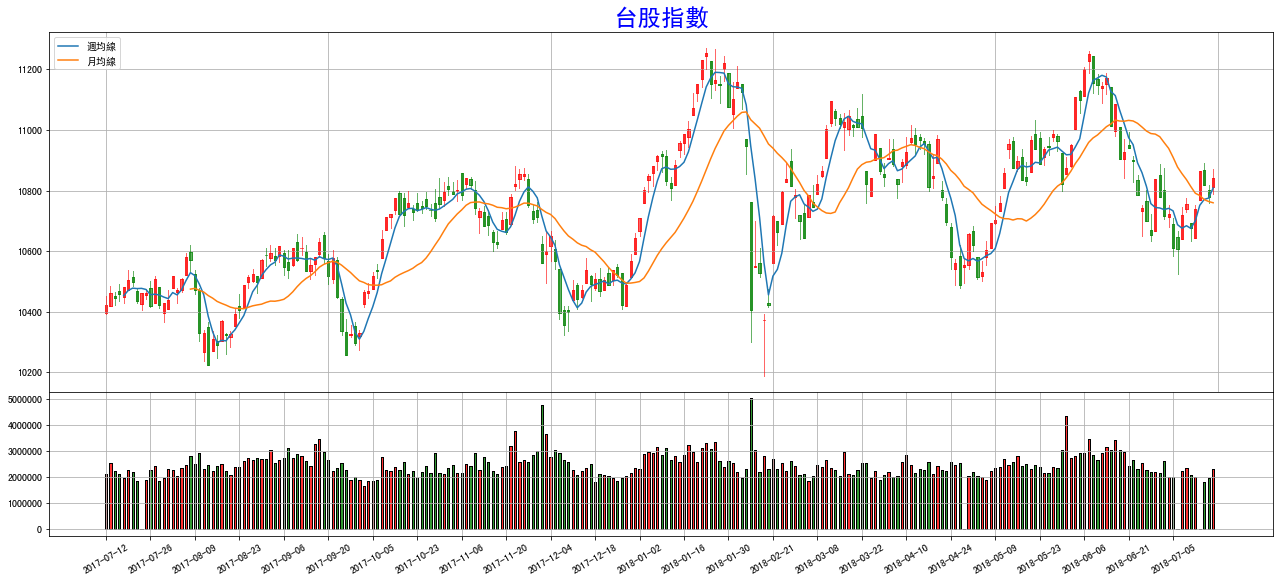

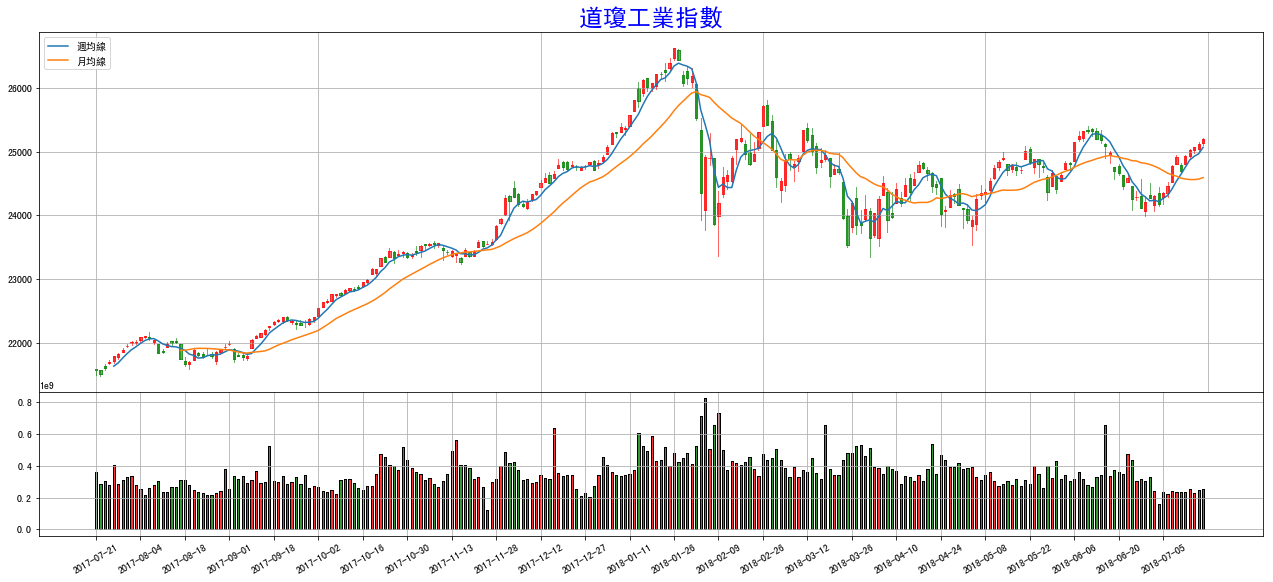

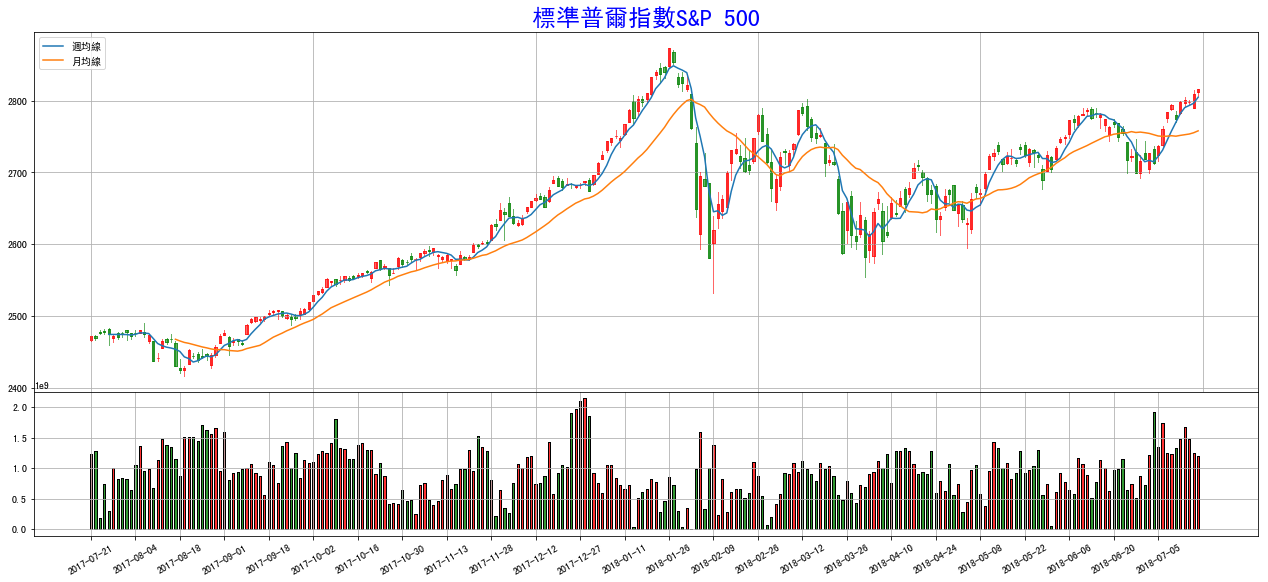

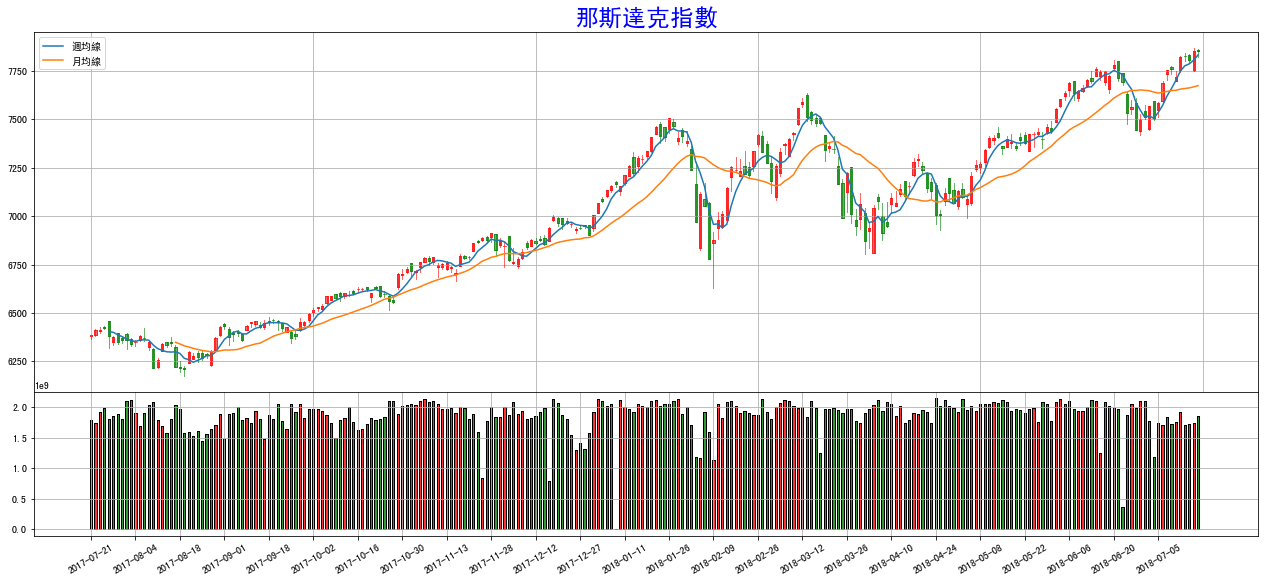

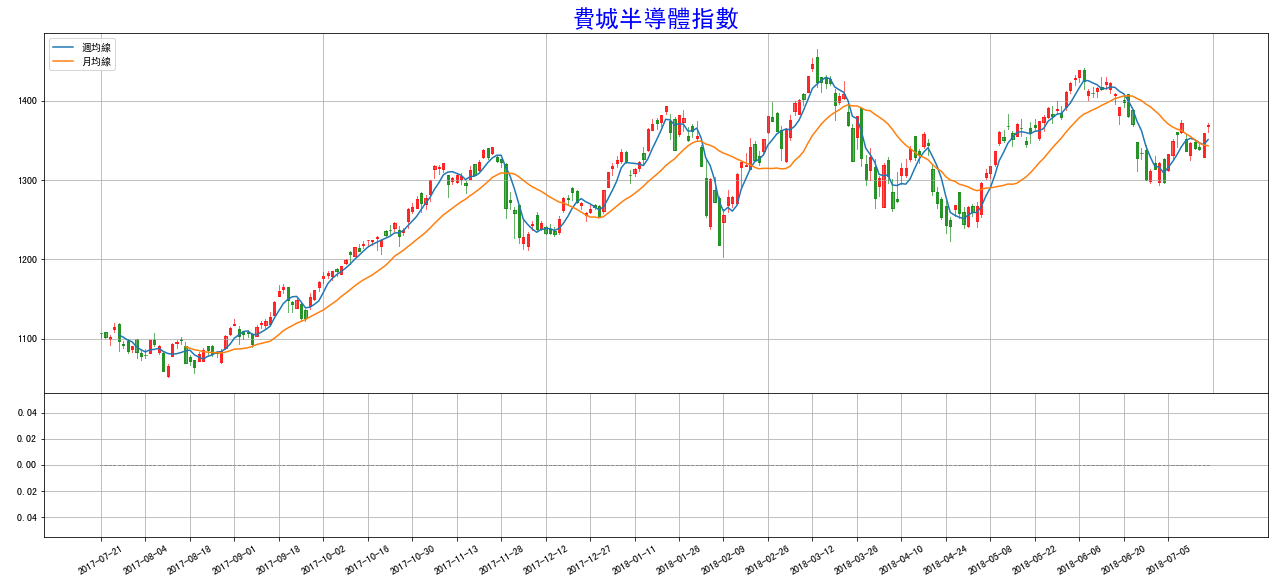

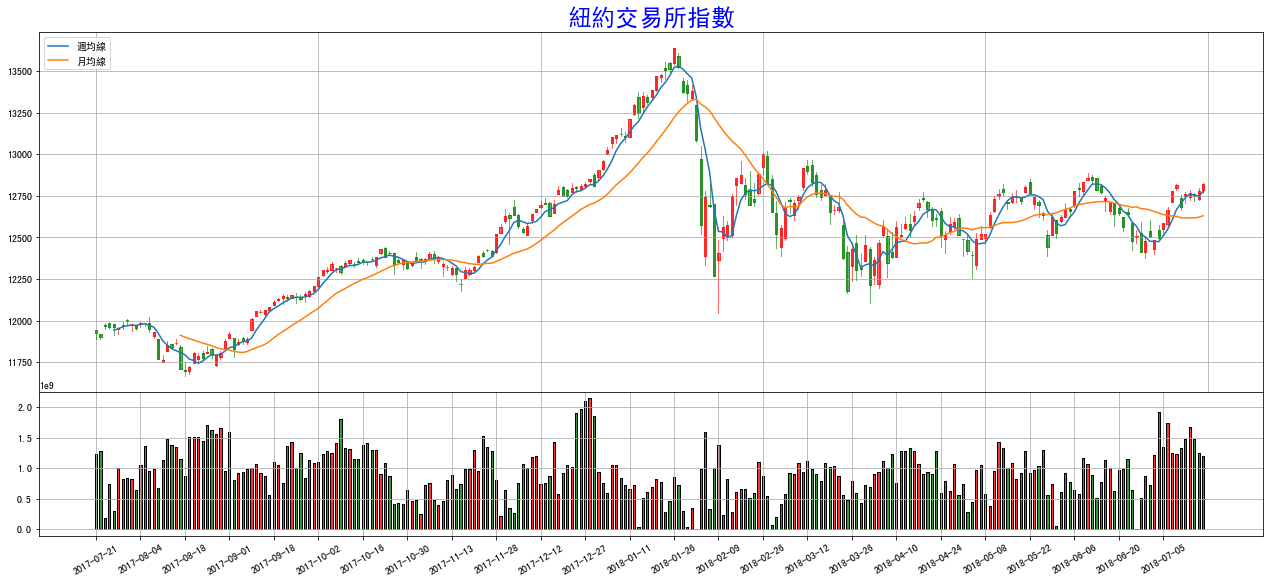

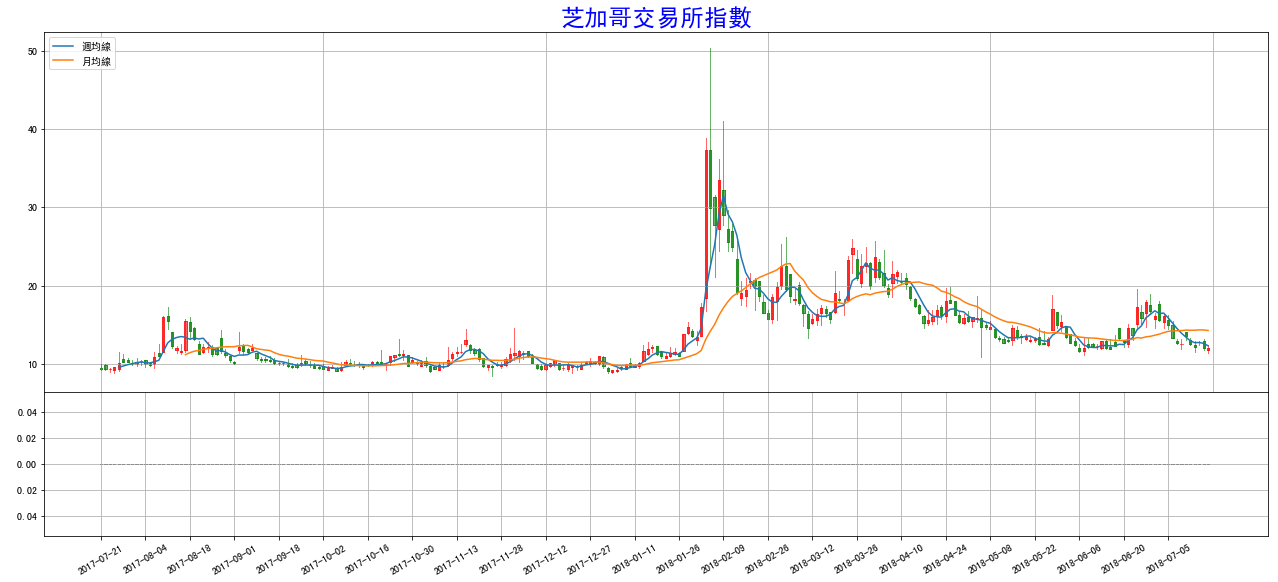

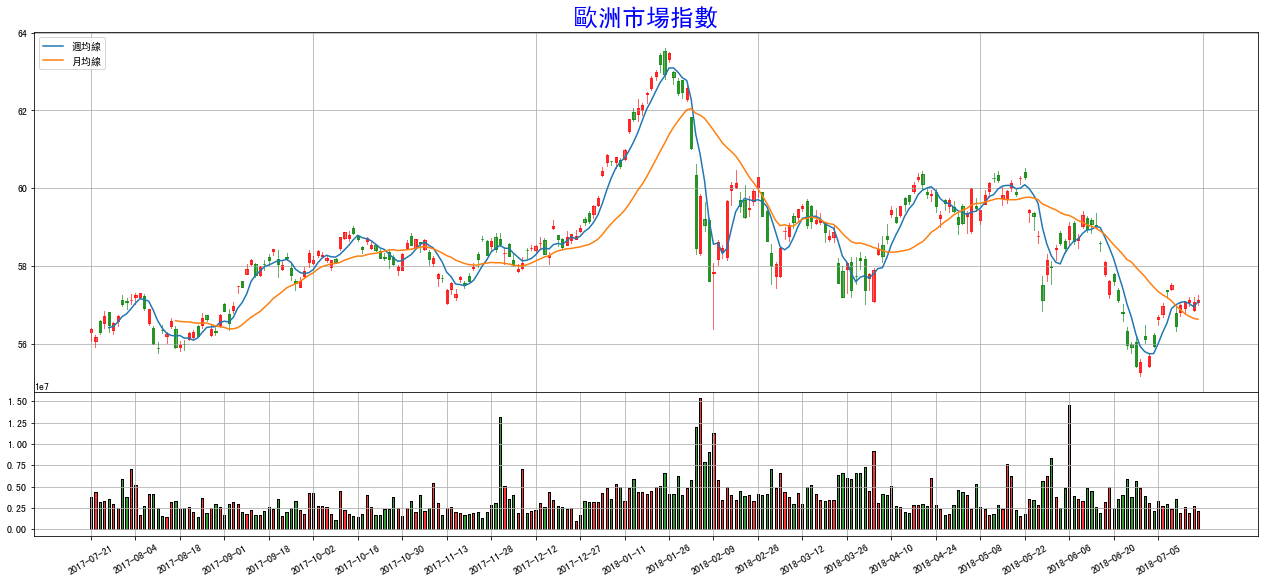

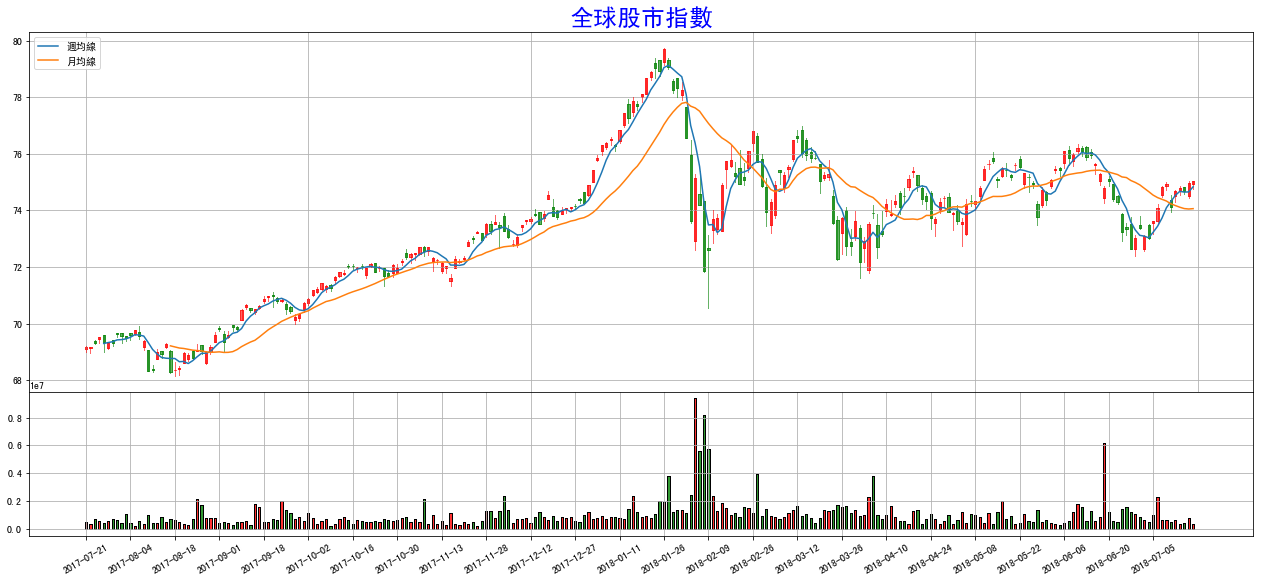

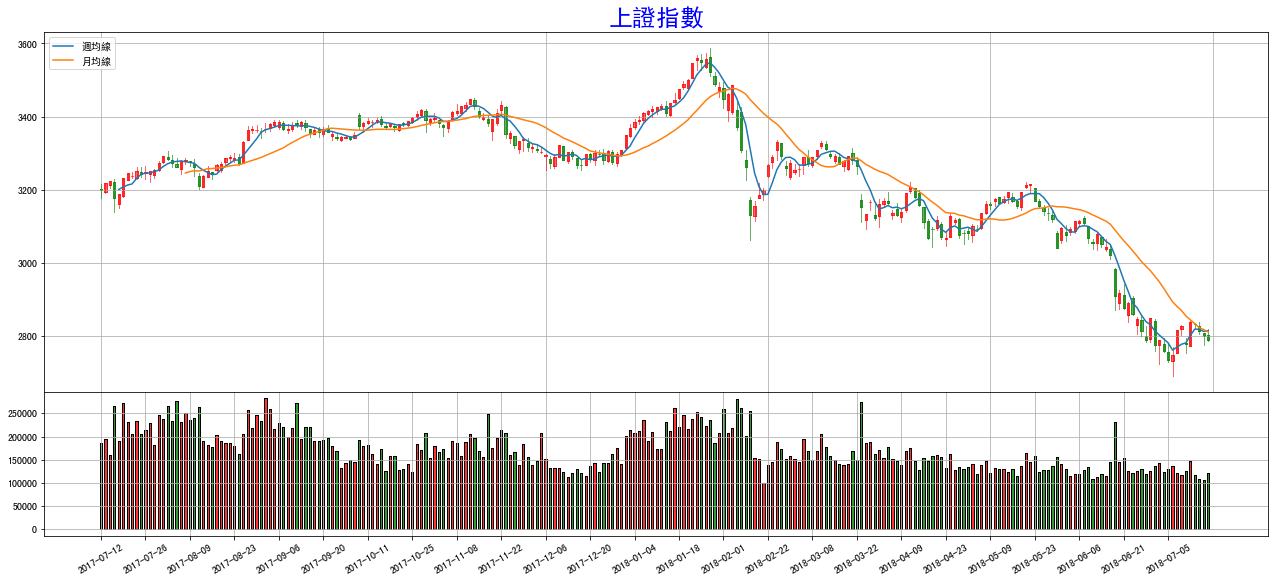

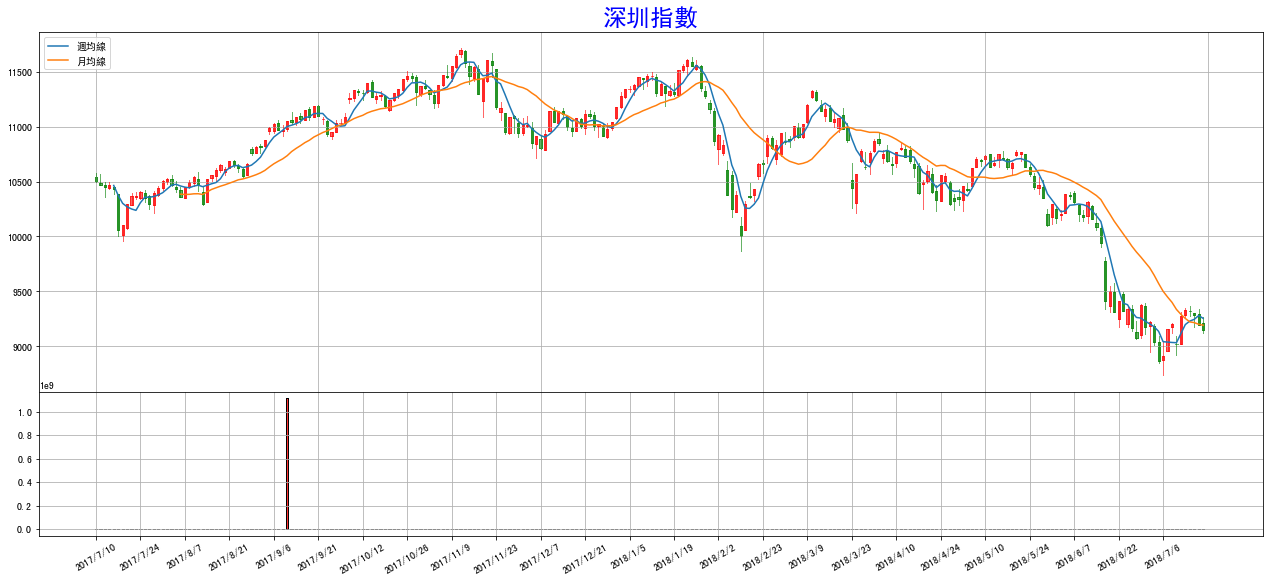

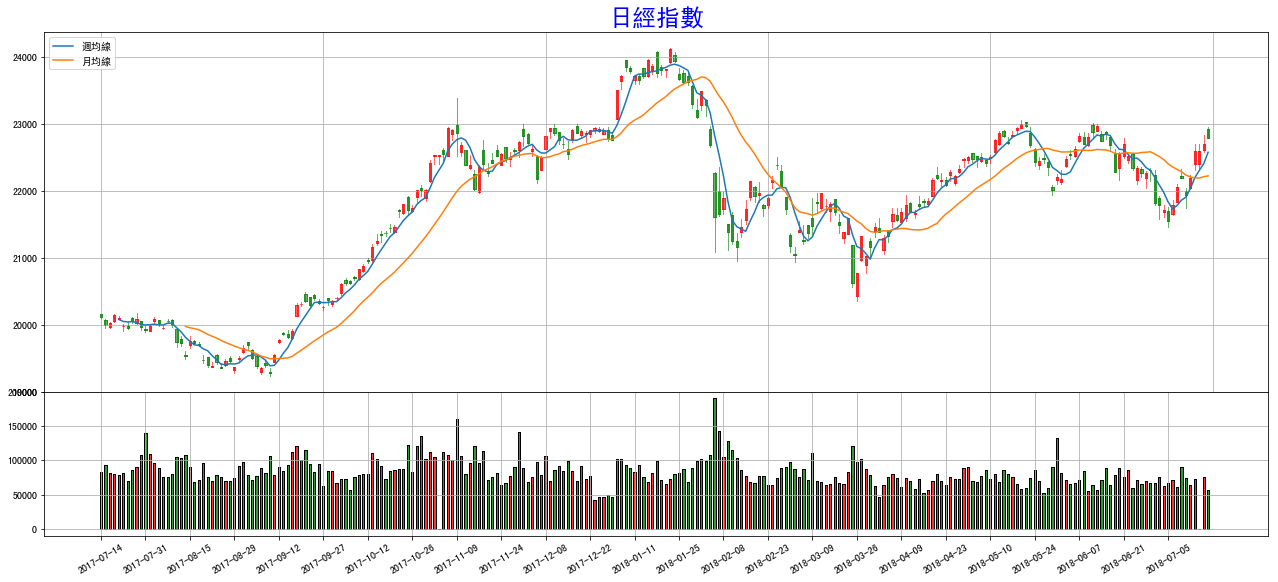

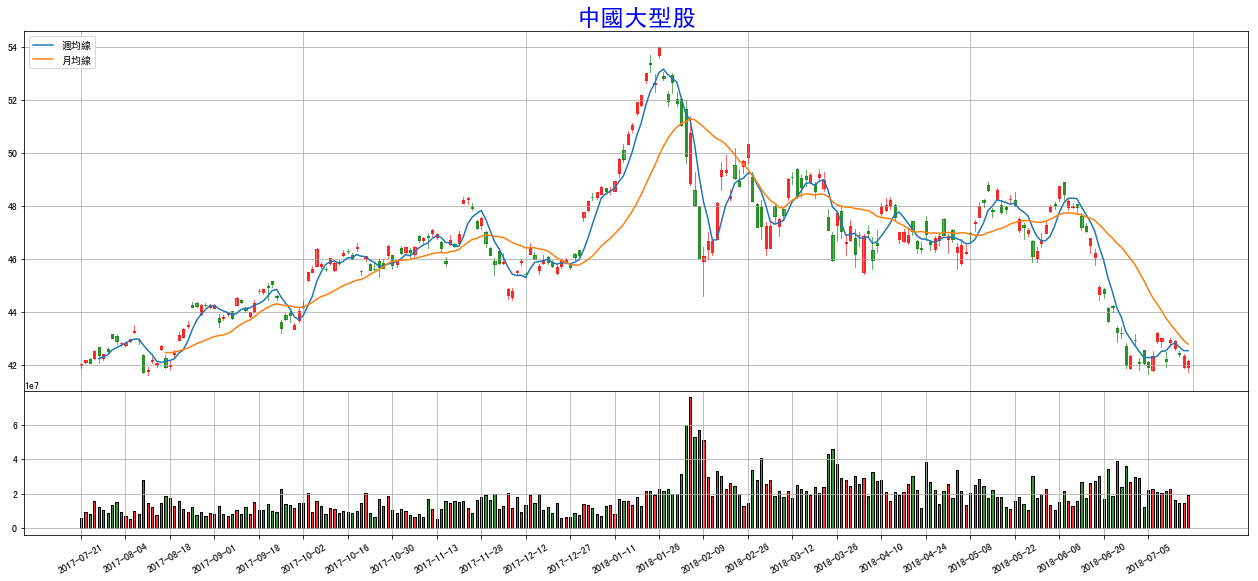

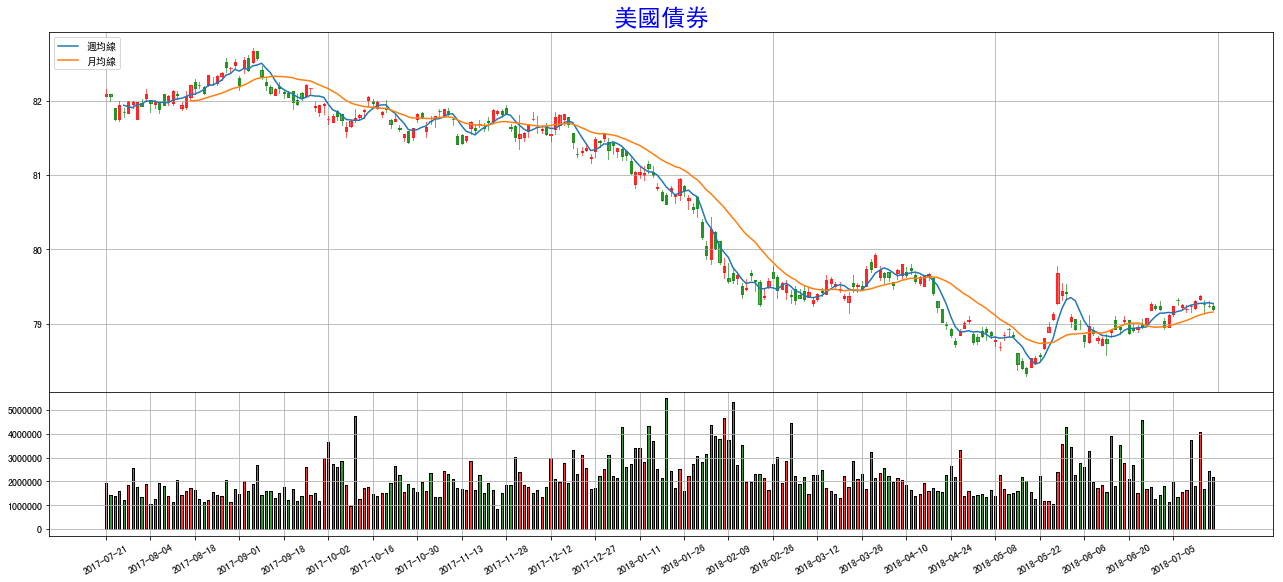

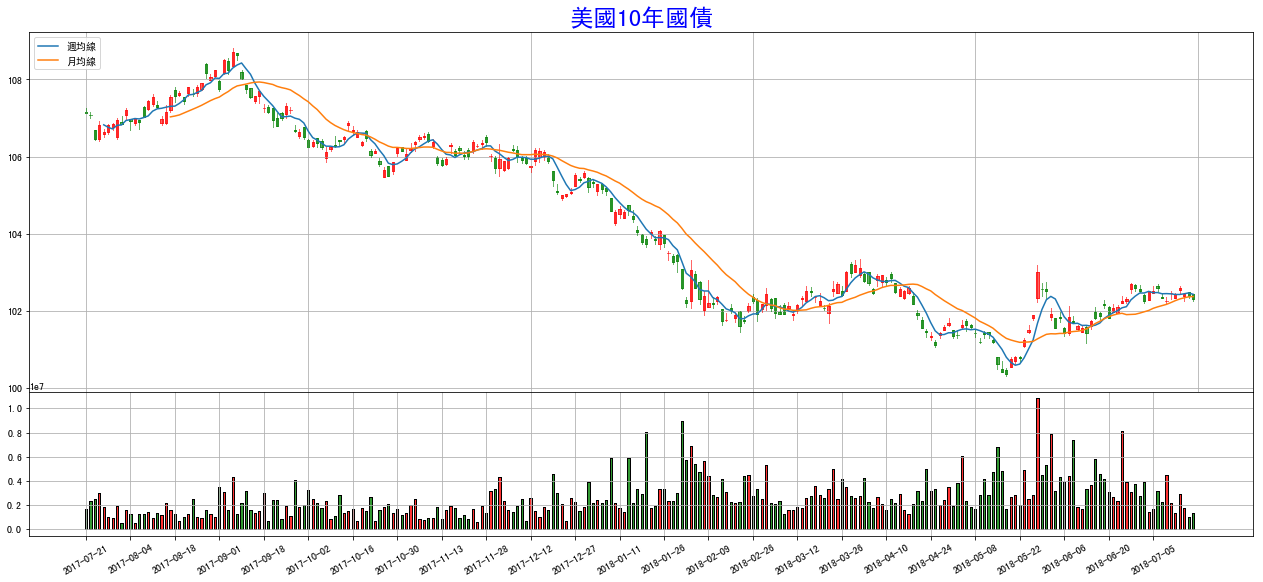

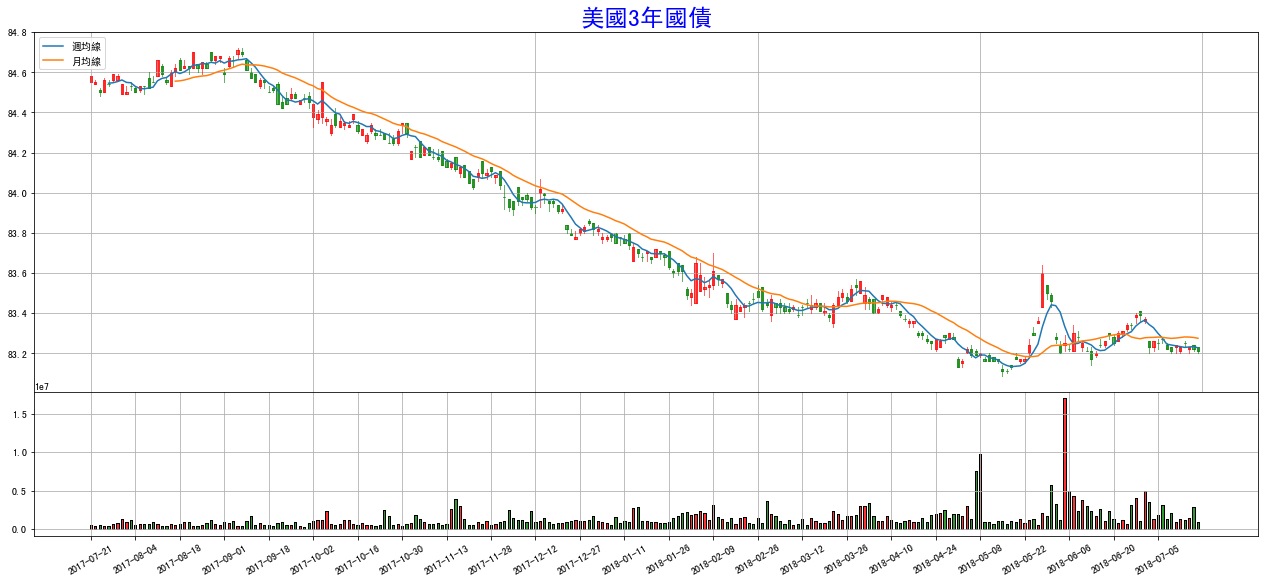

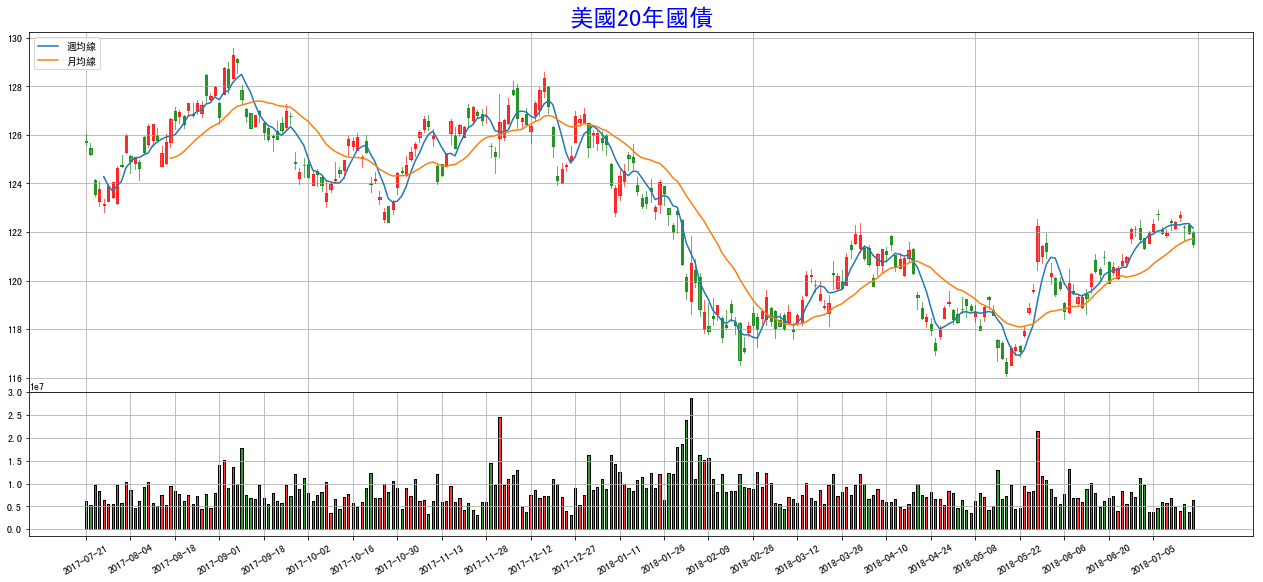

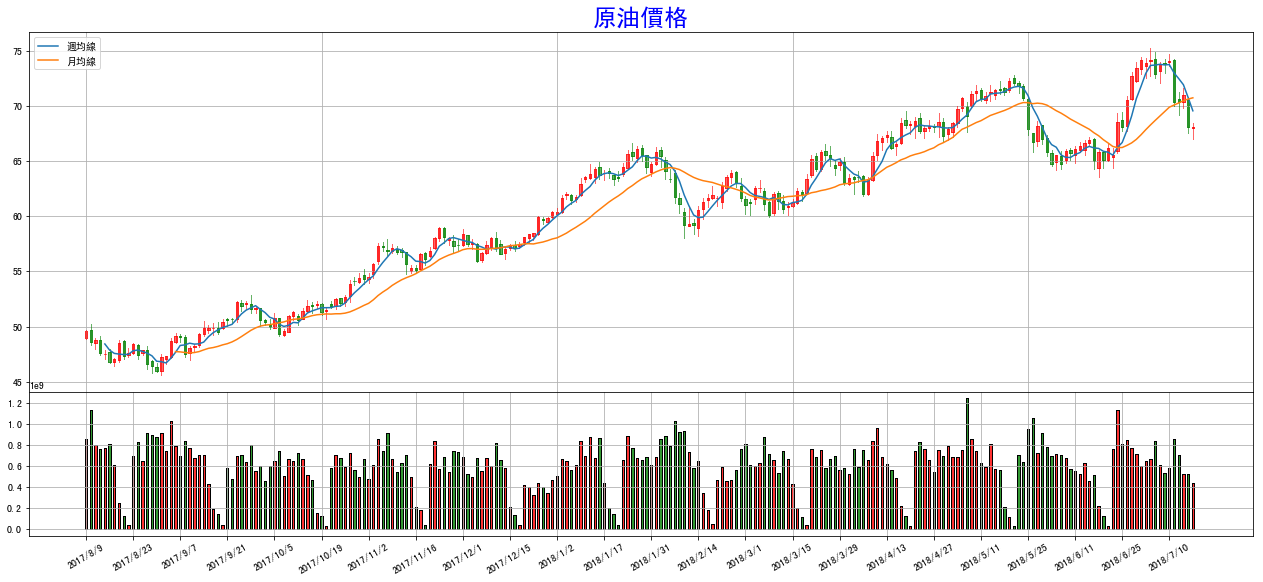

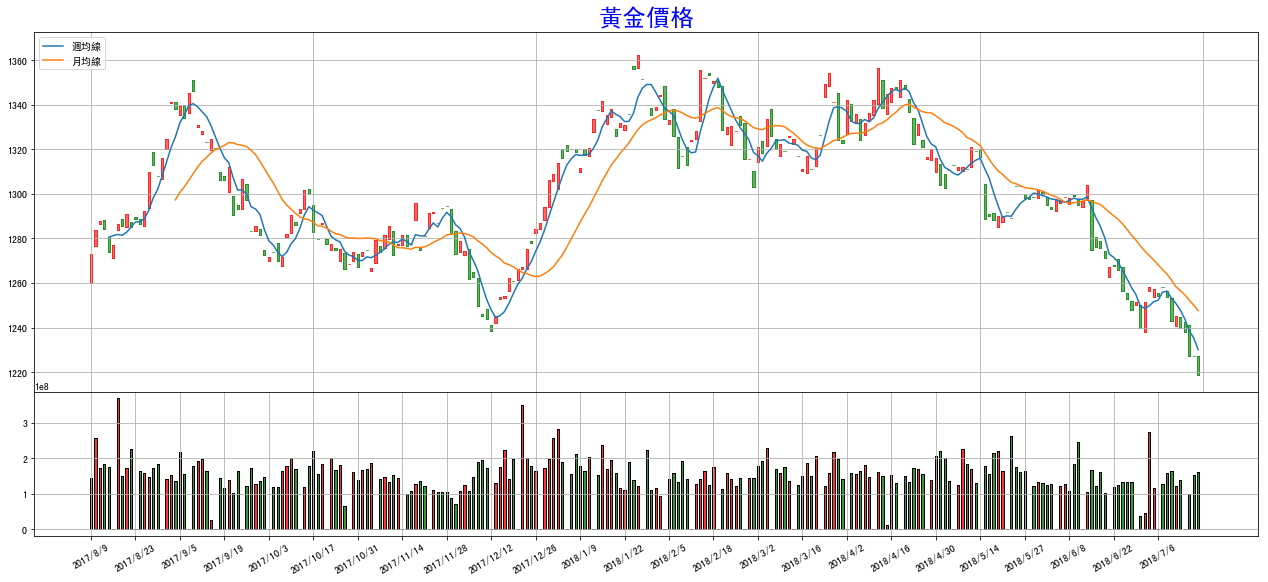

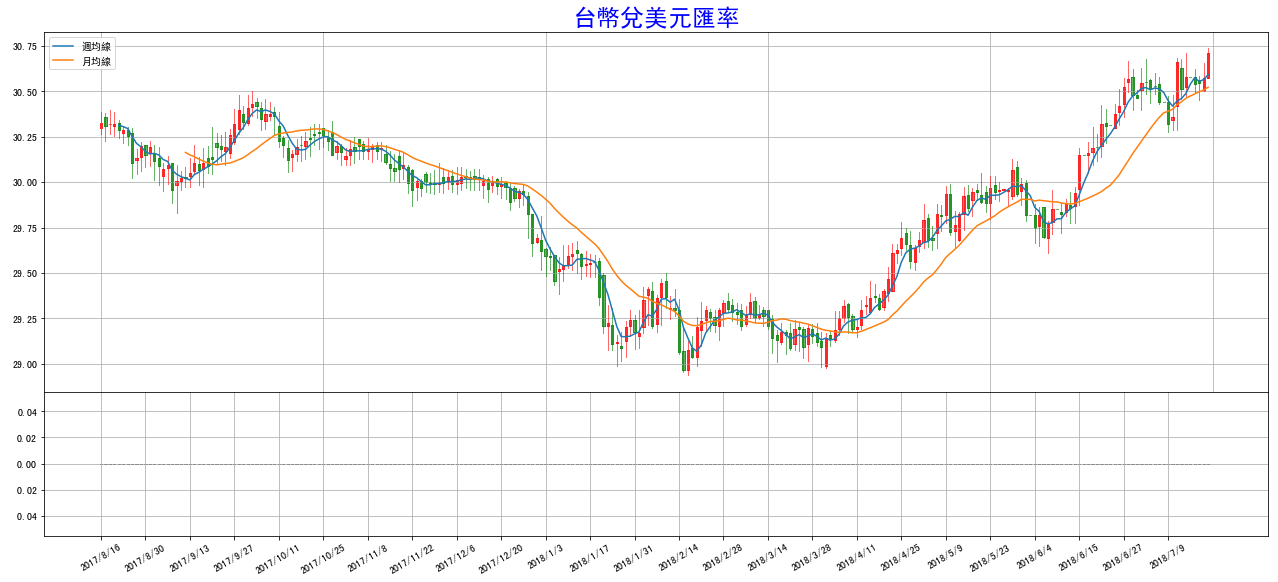

In [165]:
%matplotlib inline
import talib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mpl_finance as mpf

#取值長度，即從最後一筆往回推幾天，預設以250營業日為一年。
data_len = 250
para_array = ['^TWII', '^DJI', '^GSPC', '^IXIC', '^SOX', '^NYA', '^VIX', 'VGK', 'VT', '000001.SS', '399001.SZ', '^N225', 'FXI', 'BND', 'IEF', 'SHY', 'TLT', 'CL=F', 'GC=F', 'TWD=X']
title_array = ['台股指數', '道瓊工業指數', '標準普爾指數S&P 500', '那斯達克指數', '費城半導體指數', '紐約交易所指數', '芝加哥交易所指數', '歐洲市場指數', '全球股市指數', '上證指數', '深圳指數', '日經指數', '中國大型股', '美國債券', '美國10年國債', '美國3年國債', '美國20年國債', '原油價格', '黃金價格', '台幣兌美元匯率']
para = zip(para_array,title_array)
#從檔案逐一讀取各變項資料
for para_code in para:
    df = pd.read_csv('datasets/'+para_code[0]+'-history.csv')
    df.index = df.Date
    data = df[-data_len:][:].dropna()
    #取5日移動平均週線，20日移動平均月線
    sma_5 = talib.SMA(np.array(data['Close']), 5)
    sma_20 = talib.SMA(np.array(data['Close']), 20)
    fig = plt.figure(figsize=(17, 10))
    ax = fig.add_axes([0,0.2,1,0.5])
    ax2 = fig.add_axes([0,0,1,0.2])
    #蠟燭圖
    mpf.candlestick2_ochl(ax, data['Open'], data['Close'], data['High'], data['Low'], width=0.5, colorup='r', colordown='green', alpha=0.6)
    #圖例
    ax.set_xticklabels(data['Date'][::10])
    ax.plot(sma_5, label='週均線')
    ax.plot(sma_20, label='月均線')
    ax.legend(loc='upper left')
    ax.grid(True)
    ax.set_title(para_code[1],fontsize=24,color='b')
    #成交量柱狀圖
    mpf.volume_overlay(ax2, data['Open'], data['Close'], data['Volume'].abs(), colorup='r', colordown='g', width=0.5, alpha=0.8)
    ax2.set_xticks(range(0, len(data['Date']), 10))
    ax2.set_xticklabels(data['Date'][::10], rotation=30)
    ax2.grid(True)
    plt.subplots_adjust(hspace=0)

若變項調整資料，則執行以下2步驟更新漲跌幅檔；否則略過此步驟。

In [120]:
para_array = ['^TWII', '^DJI', '^GSPC', '^IXIC', '^SOX', '^NYA', '^VIX', 'VGK', 'VT', '000001.SS', '399001.SZ', '^N225', 'FXI', 'BND', 'IEF', 'SHY', 'TLT', 'CL=F', 'GC=F', 'TWD=X']
#從檔案逐一讀取各變項資料，將收盤價與成交量資料轉為漲跌幅
for para_code in para_array:
    df = pd.read_csv('datasets/'+para_code+'-history.csv')
    df.index = pd.to_datetime(df.Date)
    #取出收盤價與交易量 
    df_diff = df[['Adj Close', 'Volume']]
    #計算漲跌幅
    df_diff = df_diff.diff() / df_diff.shift(1)
    #存檔
    df_diff.to_csv('datasets/'+para_code+'-diff.csv')

In [141]:
para_array = ['^TWII', '^DJI', '^GSPC', '^IXIC', '^SOX', '^NYA', '^VIX', 'VGK', 'VT', '000001.SS', '399001.SZ', '^N225', 'FXI', 'BND', 'IEF', 'SHY', 'TLT', 'CL=F', 'GC=F', 'TWD=X']
#從檔案逐一讀取各變項資料，分別合併成大表
df_type_array = ['-history.csv','-diff.csv']
for df_type in df_type_array:
    df_all = pd.read_csv('datasets/^TWII'+df_type)
    df_all.index = pd.to_datetime(df_all.Date)
    df_all = df_all.drop(columns=['Date'])
    df_all.columns = df_all.columns+'-^TWII'    
    for para_code in para_array[1:]:
        df = pd.read_csv('datasets/'+para_code+df_type)
        df.index = pd.to_datetime(df.Date)
        df = df.drop(columns=['Date'])
        df.columns = df.columns+'-'+para_code
        df_all = pd.concat([df_all, df], axis=1, join_axes=[df_all.index])
    df_all.to_csv('datasets/df_all'+df_type)

機器學習
=======

1. 以漲跌幅作為特徵檔features
2. 使用Sickit Learn框架
3. 採用Gradient Boosting Regressor隨機森林模型

In [4]:
import pandas as pd
import numpy as np
import datetime

df_all_diff = pd.read_csv('datasets/df_all-diff.csv').dropna(axis='columns',how='all')
df_all_diff.index = pd.to_datetime(df_all_diff.Date)
df_all_diff = df_all_diff.drop(columns=['Date']).fillna(0).replace(np.inf, 0).replace(-np.inf, 0)
df_all_diff = pd.DataFrame(df_all_diff,dtype=np.float32)
#取次日漲跌幅作為預測目標
df_y = df_all_diff['Adj Close-^TWII'].shift(-1)
# 將資料分成舊資料為訓練組，最近一年資料為測試組，並去除最後一日資料，因為沒有次日漲跌幅可當預測目標。
div_date = datetime.datetime.today() - datetime.timedelta(days=365)
X_train = df_all_diff[:div_date]
X_train = X_train[:-1]
X_test = df_all_diff[div_date:]
X_test = X_test[:-1]
y_train = df_y[:div_date]
y_train = y_train[:-1]
y_test = df_y[div_date:]
y_test = y_test[:-1]

In [156]:
#儲存有效特徵項清單
pd.DataFrame(df_all_diff.columns).to_csv('model_columns.csv')

訓練機器學習模型

In [4]:
from sklearn.ensemble import GradientBoostingRegressor

gb_r = GradientBoostingRegressor(max_depth=8, min_samples_leaf=9, subsample=0.8, learning_rate=0.02, n_estimators=80, verbose=1)
gb_r.fit(X_train, y_train)   # 使用一年以前資料以及預測目標(y)來訓練預測機

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0002           0.0000            3.00s
         2           0.0002           0.0000            3.02s
         3           0.0002           0.0000            2.88s
         4           0.0002           0.0000            2.78s
         5           0.0002           0.0000            2.87s
         6           0.0002           0.0000            2.97s
         7           0.0002           0.0000            2.97s
         8           0.0002           0.0000            2.92s
         9           0.0002           0.0000            2.88s
        10           0.0002           0.0000            2.83s
        20           0.0002           0.0000            2.42s
        30           0.0002           0.0000            2.00s
        40           0.0001           0.0000            1.56s
        50           0.0001           0.0000            1.14s
        60           0.0001          -0.0000            0.75s
       

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.02, loss='ls', max_depth=8, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=9,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=80, presort='auto', random_state=None,
             subsample=0.8, verbose=1, warm_start=False)

匯出機器學習模型

In [5]:
from sklearn.externals import joblib  # 使用joblib.dump匯出預測模型
joblib.dump(gb_r, "GradientBoostingRegressor.pkl")

['GradientBoostingRegressor.pkl']

篩選特徵變項
----------
以Boruta機器學習模型從變項中篩選出有影響力的變項

In [186]:
from boruta import BorutaPy
# 設定Boruta特徵變項選取參數
feat_selector = BorutaPy(gb_r, n_estimators=500, verbose=2, random_state=None)
# 找出特徵變項
feat_selector.fit(np.array(X_train), np.array(y_train))
print(feat_selector.support_)
print(X_train.columns[feat_selector.support_])

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0002           0.0000           35.49s
         2           0.0002           0.0000           36.00s
         3           0.0002           0.0000           36.82s
         4           0.0002           0.0000           36.40s
         5           0.0002           0.0000           36.04s
         6           0.0002           0.0000           35.67s
         7           0.0002           0.0000           35.77s
         8           0.0002           0.0000           35.38s
         9           0.0002           0.0000           35.83s
        10           0.0002           0.0000           35.52s
        20           0.0002           0.0000           34.53s
        30           0.0001           0.0000           34.83s
        40           0.0001           0.0000           33.89s
        50           0.0001           0.0000           32.63s
        60           0.0001           0.0000           32.04s
       

         9           0.0002           0.0000           39.67s
        10           0.0002           0.0000           39.08s
        20           0.0002           0.0000           37.77s
        30           0.0001           0.0000           37.21s
        40           0.0001           0.0000           38.07s
        50           0.0001          -0.0000           36.80s
        60           0.0001           0.0000           36.43s
        70           0.0001          -0.0000           35.42s
        80           0.0001          -0.0000           34.71s
        90           0.0001          -0.0000           33.84s
       100           0.0001          -0.0000           32.71s
       200           0.0001           0.0000           22.46s
       300           0.0000          -0.0000           15.22s
       400           0.0000          -0.0000            7.45s
       500           0.0000          -0.0000            0.00s
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	38
Rejected: 	0
      It

/Users/allez/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


        20           0.0002           0.0000            5.45s
        30           0.0002           0.0000            5.22s
        40           0.0001           0.0000            5.04s
        50           0.0001           0.0000            4.90s
        60           0.0001          -0.0000            4.74s
        70           0.0001          -0.0000            4.60s
        80           0.0001          -0.0000            4.46s
        90           0.0001           0.0000            4.32s
       100           0.0001          -0.0000            4.17s
       200           0.0001          -0.0000            2.97s
       300           0.0001          -0.0000            1.94s
       400           0.0001          -0.0000            0.96s
       500           0.0001          -0.0000            0.00s
Iteration: 	10 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	33
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0002           0.0000            5.28s
      

/Users/allez/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


        20           0.0002           0.0000            5.30s
        30           0.0002           0.0000            5.10s
        40           0.0001           0.0000            4.97s
        50           0.0001           0.0000            4.83s
        60           0.0001           0.0000            4.69s
        70           0.0001           0.0000            4.54s
        80           0.0001          -0.0000            4.40s
        90           0.0001          -0.0000            4.27s
       100           0.0001          -0.0000            4.12s
       200           0.0001          -0.0000            2.89s
       300           0.0001          -0.0000            1.88s
       400           0.0001          -0.0000            0.93s
       500           0.0001          -0.0000            0.00s
Iteration: 	11 / 100
Confirmed: 	2
Tentative: 	3
Rejected: 	33
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0002           0.0000            5.27s
      

/Users/allez/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


        20           0.0002           0.0000            5.21s
        30           0.0002          -0.0000            5.11s
        40           0.0001          -0.0000            4.98s
        50           0.0001          -0.0000            4.83s
        60           0.0001          -0.0000            4.72s
        70           0.0001          -0.0000            4.60s
        80           0.0001           0.0000            4.52s
        90           0.0001          -0.0000            4.41s
       100           0.0001          -0.0000            4.25s
       200           0.0001          -0.0000            2.94s
       300           0.0001          -0.0000            1.91s
       400           0.0001          -0.0000            0.95s
       500           0.0001          -0.0000            0.00s
Iteration: 	12 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	33
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0002           0.0000            5.99s
      

/Users/allez/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


        20           0.0002           0.0000            5.85s
        30           0.0002           0.0000            5.55s
        40           0.0001           0.0000            5.26s
        50           0.0001           0.0000            5.09s
        60           0.0001           0.0000            5.41s
        70           0.0001          -0.0000            5.63s
        80           0.0001          -0.0000            5.47s
        90           0.0001          -0.0000            5.31s
       100           0.0001          -0.0000            5.20s
       200           0.0001          -0.0000            3.61s
       300           0.0001          -0.0000            2.20s
       400           0.0001          -0.0000            1.06s
       500           0.0001          -0.0000            0.00s
Iteration: 	13 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	33
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0002           0.0000            5.85s
      

/Users/allez/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


        20           0.0002           0.0000            5.27s
        30           0.0002           0.0000            5.13s
        40           0.0001           0.0000            4.98s
        50           0.0001           0.0000            4.83s
        60           0.0001           0.0000            4.69s
        70           0.0001          -0.0000            4.56s
        80           0.0001          -0.0000            4.41s
        90           0.0001          -0.0000            4.29s
       100           0.0001          -0.0000            4.16s
       200           0.0001          -0.0000            2.91s
       300           0.0001          -0.0000            1.88s
       400           0.0001          -0.0000            0.93s
       500           0.0001          -0.0000            0.00s
Iteration: 	14 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	33
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0002           0.0000            5.36s
      

/Users/allez/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


        20           0.0002           0.0000            5.22s
        30           0.0002           0.0000            5.04s
        40           0.0001           0.0000            4.89s
        50           0.0001           0.0000            4.77s
        60           0.0001          -0.0000            4.65s
        70           0.0001           0.0000            4.54s
        80           0.0001          -0.0000            4.39s
        90           0.0001           0.0000            4.26s
       100           0.0001          -0.0000            4.11s
       200           0.0001          -0.0000            2.89s
       300           0.0001          -0.0000            1.88s
       400           0.0001          -0.0000            0.94s
       500           0.0001          -0.0000            0.00s
Iteration: 	15 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	33
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0002           0.0000            5.45s
      

/Users/allez/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


        20           0.0002           0.0000            5.39s
        30           0.0002           0.0000            5.22s
        40           0.0001           0.0000            5.04s
        50           0.0001          -0.0000            4.86s
        60           0.0001          -0.0000            4.70s
        70           0.0001          -0.0000            4.58s
        80           0.0001          -0.0000            4.42s
        90           0.0001          -0.0000            4.28s
       100           0.0001          -0.0000            4.15s
       200           0.0001          -0.0000            2.89s
       300           0.0001          -0.0000            1.88s
       400           0.0001          -0.0000            0.93s
       500           0.0001          -0.0000            0.00s
Iteration: 	16 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	33
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0002           0.0000            5.41s
      

/Users/allez/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


        20           0.0002           0.0000            5.24s
        30           0.0001           0.0000            5.15s
        40           0.0001           0.0000            5.08s
        50           0.0001          -0.0000            4.94s
        60           0.0001           0.0000            4.79s
        70           0.0001          -0.0000            4.65s
        80           0.0001          -0.0000            4.48s
        90           0.0001           0.0000            4.34s
       100           0.0001          -0.0000            4.20s
       200           0.0001          -0.0000            2.91s
       300           0.0001          -0.0000            1.88s
       400           0.0001          -0.0000            0.94s
       500           0.0001          -0.0000            0.00s
Iteration: 	17 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	33
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0002           0.0000            5.59s
      

/Users/allez/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


        20           0.0002           0.0000            5.20s
        30           0.0001           0.0000            5.18s
        40           0.0001           0.0000            4.99s
        50           0.0001           0.0000            4.84s
        60           0.0001          -0.0000            4.68s
        70           0.0001          -0.0000            4.55s
        80           0.0001          -0.0000            4.42s
        90           0.0001          -0.0000            4.29s
       100           0.0001          -0.0000            4.13s
       200           0.0001          -0.0000            2.89s
       300           0.0001          -0.0000            1.88s
       400           0.0001          -0.0000            0.94s
       500           0.0001          -0.0000            0.00s
Iteration: 	18 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	33
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0002           0.0000            5.23s
      

/Users/allez/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


        20           0.0002           0.0000            5.25s
        30           0.0002           0.0000            5.08s
        40           0.0001           0.0000            4.93s
        50           0.0001          -0.0000            4.79s
        60           0.0001          -0.0000            4.64s
        70           0.0001          -0.0000            4.50s
        80           0.0001          -0.0000            4.36s
        90           0.0001          -0.0000            4.22s
       100           0.0001          -0.0000            4.08s
       200           0.0001          -0.0000            2.85s
       300           0.0001          -0.0000            1.84s
       400           0.0001          -0.0000            0.91s
       500           0.0001          -0.0000            0.00s
Iteration: 	19 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	33
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0002           0.0000            5.58s
      

/Users/allez/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


        20           0.0002           0.0000            5.29s
        30           0.0002           0.0000            5.12s
        40           0.0001           0.0000            4.96s
        50           0.0001           0.0000            4.82s
        60           0.0001           0.0000            4.67s
        70           0.0001          -0.0000            4.53s
        80           0.0001          -0.0000            4.39s
        90           0.0001          -0.0000            4.28s
       100           0.0001          -0.0000            4.15s
       200           0.0001          -0.0000            2.90s
       300           0.0001          -0.0000            1.89s
       400           0.0001          -0.0000            0.94s
       500           0.0001          -0.0000            0.00s
Iteration: 	20 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	33
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0002           0.0000            5.67s
      

/Users/allez/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


        20           0.0002           0.0000            5.28s
        30           0.0002           0.0000            5.10s
        40           0.0001           0.0000            4.97s
        50           0.0001           0.0000            4.84s
        60           0.0001           0.0000            4.67s
        70           0.0001          -0.0000            4.54s
        80           0.0001           0.0000            4.41s
        90           0.0001          -0.0000            4.28s
       100           0.0001          -0.0000            4.16s
       200           0.0001          -0.0000            2.89s
       300           0.0001          -0.0000            1.88s
       400           0.0001          -0.0000            0.94s
       500           0.0001          -0.0000            0.00s
Iteration: 	21 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	33
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0002           0.0000            5.26s
      

/Users/allez/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


        20           0.0002           0.0000            5.44s
        30           0.0002           0.0000            5.20s
        40           0.0001          -0.0000            5.00s
        50           0.0001           0.0000            4.86s
        60           0.0001          -0.0000            4.70s
        70           0.0001           0.0000            4.58s
        80           0.0001          -0.0000            4.44s
        90           0.0001          -0.0000            4.30s
       100           0.0001          -0.0000            4.16s
       200           0.0001          -0.0000            2.91s
       300           0.0001          -0.0000            1.90s
       400           0.0001          -0.0000            0.94s
       500           0.0001          -0.0000            0.00s
Iteration: 	22 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	33
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0002           0.0000            5.39s
      

/Users/allez/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


        20           0.0002           0.0000            5.25s
        30           0.0002          -0.0000            5.06s
        40           0.0001           0.0000            4.97s
        50           0.0001          -0.0000            4.83s
        60           0.0001          -0.0000            4.72s
        70           0.0001          -0.0000            4.58s
        80           0.0001          -0.0000            4.42s
        90           0.0001          -0.0000            4.28s
       100           0.0001          -0.0000            4.16s
       200           0.0001          -0.0000            2.86s
       300           0.0001          -0.0000            1.87s
       400           0.0001          -0.0000            0.93s
       500           0.0001          -0.0000            0.00s
Iteration: 	23 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	33
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0002           0.0000            5.16s
      

/Users/allez/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


        20           0.0002           0.0000            5.25s
        30           0.0002           0.0000            5.15s
        40           0.0001           0.0000            5.27s
        50           0.0001           0.0000            5.06s
        60           0.0001           0.0000            4.86s
        70           0.0001          -0.0000            4.72s
        80           0.0001          -0.0000            4.63s
        90           0.0001          -0.0000            4.48s
       100           0.0001          -0.0000            4.33s
       200           0.0001          -0.0000            3.05s
       300           0.0001          -0.0000            2.00s
       400           0.0001          -0.0000            0.99s
       500           0.0001          -0.0000            0.00s
Iteration: 	24 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	33
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0002           0.0000            5.26s
      

/Users/allez/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


        20           0.0002           0.0000            5.18s
        30           0.0002           0.0000            5.00s
        40           0.0001           0.0000            4.89s
        50           0.0001           0.0000            4.76s
        60           0.0001          -0.0000            4.63s
        70           0.0001          -0.0000            4.49s
        80           0.0001           0.0000            4.35s
        90           0.0001           0.0000            4.23s
       100           0.0001          -0.0000            4.09s
       200           0.0001          -0.0000            2.85s
       300           0.0001          -0.0000            1.86s
       400           0.0001          -0.0000            0.92s
       500           0.0001          -0.0000            0.00s
Iteration: 	25 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	33
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0002           0.0000            5.42s
      

/Users/allez/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


        20           0.0002           0.0000            5.26s
        30           0.0001          -0.0000            5.12s
        40           0.0001           0.0000            5.00s
        50           0.0001          -0.0000            4.86s
        60           0.0001           0.0000            4.71s
        70           0.0001          -0.0000            4.57s
        80           0.0001          -0.0000            4.44s
        90           0.0001          -0.0000            4.30s
       100           0.0001          -0.0000            4.16s
       200           0.0001          -0.0000            2.88s
       300           0.0001          -0.0000            1.87s
       400           0.0001           0.0000            0.94s
       500           0.0001          -0.0000            0.00s
Iteration: 	26 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	33
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0002           0.0000            5.46s
      

/Users/allez/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


        20           0.0002           0.0000            5.24s
        30           0.0002           0.0000            5.10s
        40           0.0001           0.0000            4.96s
        50           0.0001           0.0000            4.79s
        60           0.0001          -0.0000            4.64s
        70           0.0001          -0.0000            4.51s
        80           0.0001          -0.0000            4.38s
        90           0.0001          -0.0000            4.25s
       100           0.0001          -0.0000            4.13s
       200           0.0001          -0.0000            2.85s
       300           0.0001          -0.0000            1.84s
       400           0.0001          -0.0000            0.92s
       500           0.0001          -0.0000            0.00s
Iteration: 	27 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	33
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0002           0.0000            5.59s
      

/Users/allez/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


        20           0.0002           0.0000            5.23s
        30           0.0002           0.0000            5.05s
        40           0.0001           0.0000            4.89s
        50           0.0001           0.0000            4.77s
        60           0.0001           0.0000            4.64s
        70           0.0001          -0.0000            4.53s
        80           0.0001          -0.0000            4.40s
        90           0.0001           0.0000            4.28s
       100           0.0001          -0.0000            4.13s
       200           0.0001          -0.0000            2.88s
       300           0.0001          -0.0000            1.88s
       400           0.0001          -0.0000            0.95s
       500           0.0001          -0.0000            0.00s
Iteration: 	28 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	33
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0002           0.0000            5.28s
      

/Users/allez/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


        20           0.0002           0.0000            5.31s
        30           0.0002           0.0000            5.14s
        40           0.0001           0.0000            4.97s
        50           0.0001           0.0000            4.87s
        60           0.0001          -0.0000            4.70s
        70           0.0001          -0.0000            4.57s
        80           0.0001           0.0000            4.41s
        90           0.0001          -0.0000            4.28s
       100           0.0001          -0.0000            4.13s
       200           0.0001          -0.0000            2.95s
       300           0.0001          -0.0000            1.96s
       400           0.0001          -0.0000            1.05s
       500           0.0001          -0.0000            0.00s
Iteration: 	29 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	33
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0002           0.0000            8.82s
      

/Users/allez/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


        20           0.0002           0.0000            7.10s
        30           0.0002           0.0000            7.81s
        40           0.0001           0.0000            7.34s
        50           0.0001           0.0000            7.27s
        60           0.0001           0.0000            6.88s
        70           0.0001          -0.0000            6.37s
        80           0.0001          -0.0000            5.97s
        90           0.0001           0.0000            5.65s
       100           0.0001          -0.0000            5.37s
       200           0.0001          -0.0000            3.38s
       300           0.0001          -0.0000            2.09s
       400           0.0001          -0.0000            1.03s
       500           0.0001          -0.0000            0.00s
Iteration: 	30 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	33
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0002           0.0000            5.71s
      

/Users/allez/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


        20           0.0002           0.0000            5.74s
        30           0.0002           0.0000            5.40s
        40           0.0001          -0.0000            5.15s
        50           0.0001           0.0000            5.00s
        60           0.0001           0.0000            4.82s
        70           0.0001          -0.0000            4.67s
        80           0.0001          -0.0000            4.51s
        90           0.0001          -0.0000            4.37s
       100           0.0001          -0.0000            4.23s
       200           0.0001           0.0000            2.95s
       300           0.0001          -0.0000            1.90s
       400           0.0001          -0.0000            0.95s
       500           0.0001          -0.0000            0.00s
Iteration: 	31 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	33
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0002           0.0000            5.58s
      

/Users/allez/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


        20           0.0002           0.0000            5.25s
        30           0.0002           0.0000            5.11s
        40           0.0001          -0.0000            5.00s
        50           0.0001           0.0000            4.86s
        60           0.0001           0.0000            4.72s
        70           0.0001          -0.0000            4.59s
        80           0.0001          -0.0000            4.44s
        90           0.0001          -0.0000            4.30s
       100           0.0001          -0.0000            4.15s
       200           0.0001          -0.0000            2.91s
       300           0.0001          -0.0000            1.87s
       400           0.0001          -0.0000            0.93s
       500           0.0001          -0.0000            0.00s
Iteration: 	32 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	33
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0002           0.0000            5.48s
      

/Users/allez/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


        20           0.0002           0.0000            5.19s
        30           0.0002           0.0000            5.04s
        40           0.0001          -0.0000            4.88s
        50           0.0001           0.0000            4.77s
        60           0.0001          -0.0000            4.63s
        70           0.0001          -0.0000            4.51s
        80           0.0001          -0.0000            4.38s
        90           0.0001          -0.0000            4.24s
       100           0.0001           0.0000            4.10s
       200           0.0001          -0.0000            2.89s
       300           0.0001          -0.0000            1.88s
       400           0.0001          -0.0000            0.94s
       500           0.0001          -0.0000            0.00s
Iteration: 	33 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	33
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0002           0.0000            5.33s
      

/Users/allez/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


        20           0.0002           0.0000            5.24s
        30           0.0002           0.0000            5.10s
        40           0.0001          -0.0000            4.96s
        50           0.0001          -0.0000            4.81s
        60           0.0001          -0.0000            4.66s
        70           0.0001          -0.0000            4.53s
        80           0.0001          -0.0000            4.37s
        90           0.0001          -0.0000            4.23s
       100           0.0001          -0.0000            4.12s
       200           0.0001          -0.0000            2.89s
       300           0.0001          -0.0000            1.88s
       400           0.0001          -0.0000            0.94s
       500           0.0001          -0.0000            0.00s
Iteration: 	34 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	33
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0002           0.0000            5.42s
      

/Users/allez/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


        20           0.0002           0.0000            5.27s
        30           0.0002           0.0000            5.13s
        40           0.0001          -0.0000            5.01s
        50           0.0001           0.0000            4.85s
        60           0.0001          -0.0000            4.69s
        70           0.0001          -0.0000            4.55s
        80           0.0001           0.0000            4.40s
        90           0.0001          -0.0000            4.26s
       100           0.0001          -0.0000            4.12s
       200           0.0001          -0.0000            2.90s
       300           0.0001          -0.0000            1.89s
       400           0.0001          -0.0000            0.94s
       500           0.0001          -0.0000            0.00s
Iteration: 	35 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	33
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0002           0.0000            5.37s
      

/Users/allez/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


        20           0.0002           0.0000            5.23s
        30           0.0001           0.0000            5.03s
        40           0.0001           0.0000            4.90s
        50           0.0001          -0.0000            4.76s
        60           0.0001           0.0000            4.63s
        70           0.0001          -0.0000            4.51s
        80           0.0001          -0.0000            4.39s
        90           0.0001          -0.0000            4.26s
       100           0.0001          -0.0000            4.14s
       200           0.0001          -0.0000            2.91s
       300           0.0001          -0.0000            1.88s
       400           0.0001          -0.0000            0.94s
       500           0.0001          -0.0000            0.00s
Iteration: 	36 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	33
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0002           0.0000            5.37s
      

/Users/allez/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


        20           0.0002           0.0000            5.29s
        30           0.0002           0.0000            5.15s
        40           0.0001           0.0000            5.02s
        50           0.0001           0.0000            4.88s
        60           0.0001           0.0000            4.73s
        70           0.0001          -0.0000            4.59s
        80           0.0001          -0.0000            4.45s
        90           0.0001          -0.0000            4.32s
       100           0.0001          -0.0000            4.19s
       200           0.0001          -0.0000            2.92s
       300           0.0001          -0.0000            1.89s
       400           0.0001          -0.0000            0.94s
       500           0.0001          -0.0000            0.00s
Iteration: 	37 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	33
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0002           0.0000            5.50s
      

/Users/allez/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


        20           0.0002           0.0000            5.20s
        30           0.0002           0.0000            5.15s
        40           0.0001           0.0000            4.99s
        50           0.0001          -0.0000            4.85s
        60           0.0001           0.0000            4.70s
        70           0.0001          -0.0000            4.57s
        80           0.0001          -0.0000            4.42s
        90           0.0001          -0.0000            4.29s
       100           0.0001          -0.0000            4.15s
       200           0.0001          -0.0000            2.88s
       300           0.0001          -0.0000            1.87s
       400           0.0001          -0.0000            0.93s
       500           0.0001          -0.0000            0.00s
Iteration: 	38 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	33
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0002           0.0000            5.30s
      

/Users/allez/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


        20           0.0002           0.0000            5.28s
        30           0.0001           0.0000            5.12s
        40           0.0001          -0.0000            4.99s
        50           0.0001           0.0000            4.87s
        60           0.0001          -0.0000            4.74s
        70           0.0001           0.0000            4.59s
        80           0.0001          -0.0000            4.43s
        90           0.0001          -0.0000            4.29s
       100           0.0001          -0.0000            4.14s
       200           0.0001          -0.0000            2.91s
       300           0.0001          -0.0000            1.89s
       400           0.0001          -0.0000            0.94s
       500           0.0001          -0.0000            0.00s
Iteration: 	39 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	33
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0002           0.0000            5.40s
      

/Users/allez/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


        20           0.0002           0.0000            5.28s
        30           0.0002          -0.0000            5.09s
        40           0.0001           0.0000            4.96s
        50           0.0001           0.0000            4.81s
        60           0.0001           0.0000            4.67s
        70           0.0001           0.0000            4.53s
        80           0.0001          -0.0000            4.39s
        90           0.0001          -0.0000            4.26s
       100           0.0001          -0.0000            4.12s
       200           0.0001          -0.0000            2.87s
       300           0.0001          -0.0000            1.87s
       400           0.0001          -0.0000            0.96s
       500           0.0001          -0.0000            0.00s
Iteration: 	40 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	33
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0002           0.0000           11.22s
      

/Users/allez/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


         8           0.0002           0.0000           10.74s
         9           0.0002           0.0000           10.93s
        10           0.0002           0.0000           10.89s
        20           0.0002           0.0000            8.02s
        30           0.0002           0.0000            6.96s
        40           0.0001           0.0000            6.43s
        50           0.0001           0.0000            6.06s
        60           0.0001          -0.0000            5.78s
        70           0.0001           0.0000            5.64s
        80           0.0001          -0.0000            5.40s
        90           0.0001          -0.0000            5.14s
       100           0.0001           0.0000            5.04s
       200           0.0001          -0.0000            3.56s
       300           0.0001          -0.0000            2.39s
       400           0.0001          -0.0000            1.20s
       500           0.0001          -0.0000            0.00s
Iteratio

/Users/allez/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


        20           0.0002           0.0000            5.39s
        30           0.0002           0.0000            5.78s
        40           0.0001          -0.0000            5.89s
        50           0.0001           0.0000            5.77s
        60           0.0001          -0.0000            5.68s
        70           0.0001           0.0000            5.67s
        80           0.0001           0.0000            5.57s
        90           0.0001          -0.0000            5.41s
       100           0.0001          -0.0000            5.24s
       200           0.0001          -0.0000            3.74s
       300           0.0001          -0.0000            2.49s
       400           0.0001          -0.0000            1.26s
       500           0.0001          -0.0000            0.00s
Iteration: 	42 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	33
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0002           0.0000            7.66s
      

/Users/allez/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


        10           0.0002           0.0000            7.26s
        20           0.0002           0.0000            7.03s
        30           0.0002           0.0000            6.61s
        40           0.0001           0.0000            6.75s
        50           0.0001          -0.0000            6.60s
        60           0.0001          -0.0000            6.38s
        70           0.0001           0.0000            6.17s
        80           0.0001           0.0000            6.03s
        90           0.0001          -0.0000            5.87s
       100           0.0001           0.0000            5.67s
       200           0.0001          -0.0000            3.93s
       300           0.0001          -0.0000            2.54s
       400           0.0001          -0.0000            1.25s
       500           0.0001          -0.0000            0.00s
Iteration: 	43 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	33
      Iter       Train Loss      OOB Improve   Remaining Time 
      

/Users/allez/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


        20           0.0002           0.0000            8.54s
        30           0.0002           0.0000            8.62s
        40           0.0001          -0.0000            8.09s
        50           0.0001          -0.0000            7.52s
        60           0.0001          -0.0000            7.04s
        70           0.0001          -0.0000            6.58s
        80           0.0001           0.0000            6.22s
        90           0.0001          -0.0000            5.87s
       100           0.0001           0.0000            5.54s
       200           0.0001          -0.0000            3.71s
       300           0.0001          -0.0000            2.45s
       400           0.0001          -0.0000            1.19s
       500           0.0001          -0.0000            0.00s
Iteration: 	44 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	33
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0002           0.0000            5.94s
      

/Users/allez/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


        20           0.0002           0.0000            6.24s
        30           0.0002           0.0000            5.82s
        40           0.0001          -0.0000            5.52s
        50           0.0001           0.0000            5.24s
        60           0.0001          -0.0000            5.04s
        70           0.0001           0.0000            5.22s
        80           0.0001           0.0000            5.29s
        90           0.0001          -0.0000            5.20s
       100           0.0001          -0.0000            5.12s
       200           0.0001          -0.0000            3.67s
       300           0.0001          -0.0000            2.39s
       400           0.0001          -0.0000            1.21s
       500           0.0001          -0.0000            0.00s
Iteration: 	45 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	33
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0002           0.0000            5.59s
      

/Users/allez/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


        20           0.0002           0.0000            6.42s
        30           0.0002           0.0000            6.72s
        40           0.0001           0.0000            6.22s
        50           0.0001           0.0000            5.78s
        60           0.0001           0.0000            5.46s
        70           0.0001           0.0000            5.21s
        80           0.0001          -0.0000            5.01s
        90           0.0001          -0.0000            4.88s
       100           0.0001          -0.0000            4.71s
       200           0.0001          -0.0000            3.37s
       300           0.0001          -0.0000            2.24s
       400           0.0001          -0.0000            1.12s
       500           0.0001          -0.0000            0.00s
Iteration: 	46 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	33
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0002           0.0000            5.61s
      

/Users/allez/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


        20           0.0002           0.0000            5.58s
        30           0.0002           0.0000            5.50s
        40           0.0001          -0.0000            5.36s
        50           0.0001          -0.0000            5.21s
        60           0.0001           0.0000            5.11s
        70           0.0001           0.0000            4.90s
        80           0.0001          -0.0000            4.70s
        90           0.0001          -0.0000            4.53s
       100           0.0001          -0.0000            4.36s
       200           0.0001          -0.0000            3.00s
       300           0.0001          -0.0000            1.94s
       400           0.0001          -0.0000            0.97s
       500           0.0001          -0.0000            0.00s
Iteration: 	47 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	33
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0002           0.0000            5.45s
      

/Users/allez/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


        20           0.0002           0.0000            5.16s
        30           0.0002           0.0000            5.03s
        40           0.0001           0.0000            4.89s
        50           0.0001          -0.0000            4.78s
        60           0.0001          -0.0000            4.64s
        70           0.0001          -0.0000            4.50s
        80           0.0001          -0.0000            4.38s
        90           0.0001           0.0000            4.25s
       100           0.0001          -0.0000            4.15s
       200           0.0001          -0.0000            2.90s
       300           0.0001          -0.0000            1.89s
       400           0.0001          -0.0000            0.93s
       500           0.0001          -0.0000            0.00s
Iteration: 	48 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	33
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0002           0.0000            5.37s
      

/Users/allez/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


        20           0.0002           0.0000            5.53s
        30           0.0002           0.0000            5.30s
        40           0.0001           0.0000            5.11s
        50           0.0001           0.0000            4.95s
        60           0.0001           0.0000            4.77s
        70           0.0001          -0.0000            4.63s
        80           0.0001          -0.0000            4.47s
        90           0.0001          -0.0000            4.32s
       100           0.0001          -0.0000            4.18s
       200           0.0001          -0.0000            2.89s
       300           0.0001          -0.0000            1.88s
       400           0.0001          -0.0000            0.94s
       500           0.0001          -0.0000            0.00s
Iteration: 	49 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	33
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0002           0.0000            5.59s
      

/Users/allez/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


        20           0.0002           0.0000            5.26s
        30           0.0002           0.0000            5.09s
        40           0.0001           0.0000            4.94s
        50           0.0001          -0.0000            4.81s
        60           0.0001           0.0000            4.68s
        70           0.0001          -0.0000            4.55s
        80           0.0001          -0.0000            4.41s
        90           0.0001          -0.0000            4.28s
       100           0.0001          -0.0000            4.15s
       200           0.0001          -0.0000            2.89s
       300           0.0001          -0.0000            1.89s
       400           0.0001          -0.0000            0.94s
       500           0.0001          -0.0000            0.00s
Iteration: 	50 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	33
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0002           0.0000            5.49s
      

/Users/allez/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


        20           0.0002           0.0000            5.31s
        30           0.0002           0.0000            5.13s
        40           0.0001           0.0000            4.95s
        50           0.0001           0.0000            4.82s
        60           0.0001          -0.0000            4.66s
        70           0.0001          -0.0000            4.54s
        80           0.0001          -0.0000            4.40s
        90           0.0001           0.0000            4.27s
       100           0.0001          -0.0000            4.11s
       200           0.0001          -0.0000            2.88s
       300           0.0001          -0.0000            1.87s
       400           0.0001          -0.0000            0.93s
       500           0.0001          -0.0000            0.00s
Iteration: 	51 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	33
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0002           0.0000            5.48s
      

/Users/allez/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


        20           0.0002           0.0000            5.25s
        30           0.0002           0.0000            5.12s
        40           0.0001          -0.0000            5.07s
        50           0.0001          -0.0000            4.94s
        60           0.0001           0.0000            4.94s
        70           0.0001          -0.0000            4.76s
        80           0.0001          -0.0000            4.57s
        90           0.0001          -0.0000            4.43s
       100           0.0001          -0.0000            4.29s
       200           0.0001          -0.0000            3.00s
       300           0.0001          -0.0000            1.94s
       400           0.0001          -0.0000            0.96s
       500           0.0001          -0.0000            0.00s
Iteration: 	52 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	33
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0002           0.0000            5.45s
      

/Users/allez/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


        20           0.0002           0.0000            5.30s
        30           0.0002           0.0000            5.15s
        40           0.0001           0.0000            4.97s
        50           0.0001          -0.0000            4.84s
        60           0.0001          -0.0000            4.69s
        70           0.0001          -0.0000            4.57s
        80           0.0001           0.0000            4.41s
        90           0.0001          -0.0000            4.27s
       100           0.0001          -0.0000            4.14s
       200           0.0001          -0.0000            2.89s
       300           0.0001           0.0000            1.88s
       400           0.0001          -0.0000            0.93s
       500           0.0001          -0.0000            0.00s
Iteration: 	53 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	33
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0002           0.0000            5.37s
      

/Users/allez/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


        20           0.0002           0.0000            5.29s
        30           0.0002           0.0000            5.12s
        40           0.0001           0.0000            4.95s
        50           0.0001          -0.0000            4.80s
        60           0.0001           0.0000            4.67s
        70           0.0001          -0.0000            4.54s
        80           0.0001          -0.0000            4.42s
        90           0.0001          -0.0000            4.27s
       100           0.0001          -0.0000            4.15s
       200           0.0001          -0.0000            2.91s
       300           0.0001          -0.0000            1.90s
       400           0.0001          -0.0000            0.95s
       500           0.0001          -0.0000            0.00s
Iteration: 	54 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	33
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0002           0.0000            5.43s
      

/Users/allez/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


        20           0.0002           0.0000            5.13s
        30           0.0002           0.0000            4.99s
        40           0.0001           0.0000            4.85s
        50           0.0001          -0.0000            4.76s
        60           0.0001          -0.0000            4.62s
        70           0.0001          -0.0000            4.51s
        80           0.0001          -0.0000            4.37s
        90           0.0001          -0.0000            4.24s
       100           0.0001          -0.0000            4.13s
       200           0.0001          -0.0000            2.87s
       300           0.0001          -0.0000            1.87s
       400           0.0001          -0.0000            0.93s
       500           0.0001          -0.0000            0.00s
Iteration: 	55 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	33
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0002           0.0000            5.31s
      

/Users/allez/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


        20           0.0002           0.0000            5.33s
        30           0.0002           0.0000            5.26s
        40           0.0001           0.0000            5.05s
        50           0.0001           0.0000            4.88s
        60           0.0001           0.0000            4.73s
        70           0.0001           0.0000            4.60s
        80           0.0001          -0.0000            4.47s
        90           0.0001          -0.0000            4.33s
       100           0.0001          -0.0000            4.19s
       200           0.0001          -0.0000            2.92s
       300           0.0001          -0.0000            1.88s
       400           0.0001          -0.0000            0.93s
       500           0.0001          -0.0000            0.00s
Iteration: 	56 / 100
Confirmed: 	4
Tentative: 	1
Rejected: 	33
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0002           0.0000            5.06s
      

/Users/allez/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


        20           0.0002           0.0000            5.18s
        30           0.0002           0.0000            5.12s
        40           0.0001           0.0000            4.94s
        50           0.0001          -0.0000            4.80s
        60           0.0001          -0.0000            4.68s
        70           0.0001           0.0000            4.57s
        80           0.0001          -0.0000            4.42s
        90           0.0001          -0.0000            4.29s
       100           0.0001          -0.0000            4.16s
       200           0.0001          -0.0000            2.93s
       300           0.0001          -0.0000            1.91s
       400           0.0001          -0.0000            0.95s
       500           0.0001          -0.0000            0.00s
Iteration: 	57 / 100
Confirmed: 	5
Tentative: 	0
Rejected: 	33


BorutaPy finished running.

Iteration: 	58 / 100
Confirmed: 	5
Tentative: 	0
Rejected: 	33
[ True False False False False False  

/Users/allez/anaconda3/lib/python3.6/site-packages/boruta/boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


In [230]:
para_array = ['^TWII', '^DJI', '^GSPC', '^IXIC', '^SOX', '^NYA', '^VIX', 'VGK', 'VT', '000001.SS', '399001.SZ', '^N225', 'FXI', 'BND', 'IEF', 'SHY', 'TLT', 'CL=F', 'GC=F', 'TWD=X']
title_array = ['台股指數', '道瓊工業指數', '標準普爾指數S&P 500', '那斯達克指數', '費城半導體指數', '紐約交易所指數', '芝加哥交易所指數', '歐洲市場指數', '全球股市指數', '上證指數', '深圳指數', '日經指數', '中國大型股', '美國債券', '美國10年國債', '美國3年國債', '美國20年國債', '原油價格', '黃金價格', '台幣兌美元匯率']
para1 = pd.DataFrame([title_array])
para1.columns = para_array
para1.columns = 'Adj Close-'+para1.columns
para2 = pd.DataFrame([title_array])
para2 = pd.DataFrame([title_array])+'交易量'
para2.columns = para_array
para2.columns = 'Volume-'+para2.columns
para = pd.concat([para1,para2],axis=1)
print('篩選出有顯著性的變項如下：')

篩選出有顯著性的變項如下：


In [229]:
para[X_train.columns[feat_selector.support_]]

,Adj Close-^TWII,Adj Close-^IXIC,Adj Close-^SOX,Adj Close-^NYA,Adj Close-^N225
0,台股指數,那斯達克指數,費城半導體指數,紐約交易所指數,日經指數


In [ ]:
#儲存有顯著性的特徵項清單
pd.DataFrame(X_train.columns[feat_selector.support_]).to_csv('model_columns-sim.csv')

驗證模型預測結果
-------------

In [6]:
y_pred = gb_r.predict(X_test)
y_pred = pd.DataFrame(y_pred)
y_test = pd.DataFrame(y_test)
y_pred.index = y_test.index

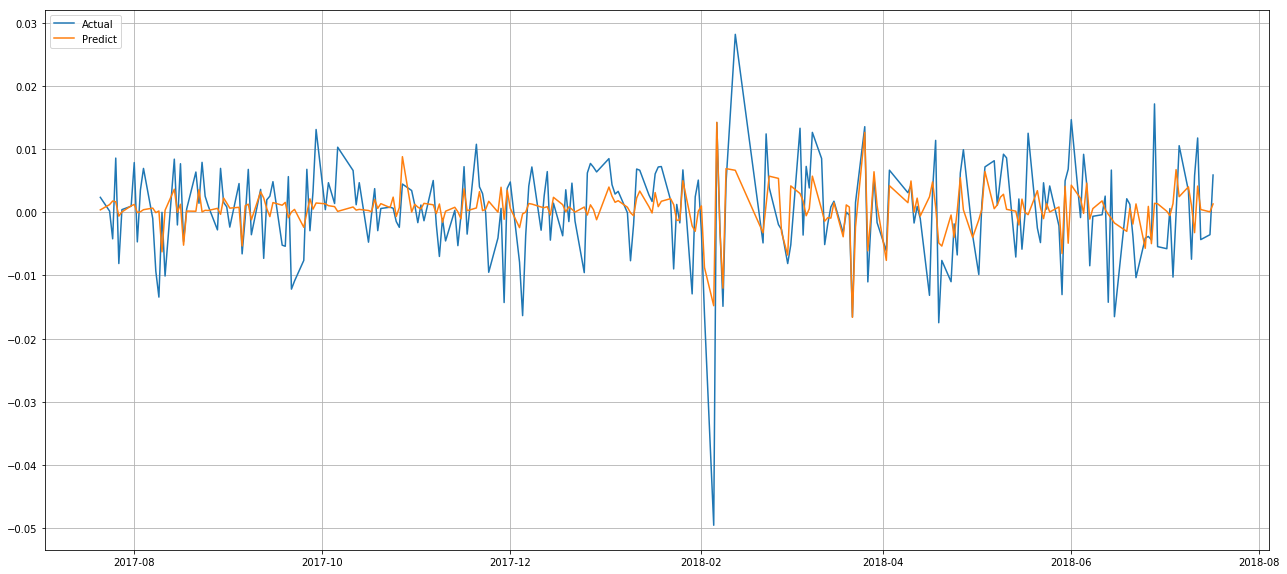

In [181]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(17, 15))
ax = fig.add_axes([0,0.2,1,0.5])
ax.plot(y_test, label='Actual')
ax.plot(y_pred, label='Predict')
ax.legend(loc='upper left')
ax.grid(True)
#ax.set_title('驗證預測漲跌幅',fontsize=24,color='b')

In [179]:
from sklearn import metrics
print("平均標準差MAE:%.4f"% metrics.mean_absolute_error(y_test, y_pred))
print("R2:%.2f"% metrics.r2_score(y_test, y_pred))

平均標準差MAE:0.0047
R2:0.30


回測模型收益

In [8]:
signal = (y_pred > 0)
df = pd.read_csv('datasets/^TWII-history.csv')
df.index = pd.to_datetime(df.Date)
y_verify = pd.DataFrame(df[y_pred.index[0]:signal.index[-1]]['Adj Close'])

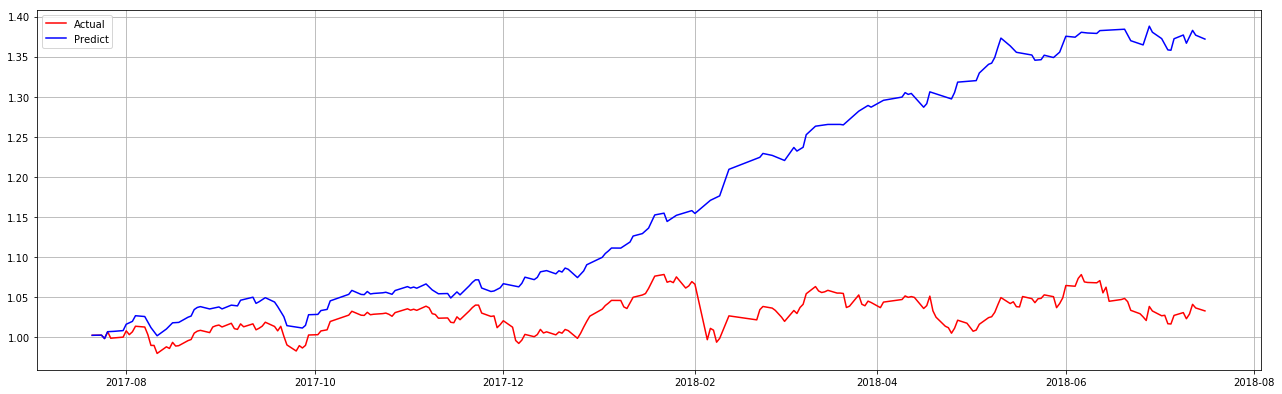

In [108]:
fig = plt.figure(figsize=(17, 10))
ax = fig.add_axes([0,0.2,1,0.5])
ax.plot((y_verify.shift(-1) / y_verify).cumprod(), label='Actual',color='red')
ax.plot((y_verify.shift(-1) / y_verify)[np.array(signal)].cumprod(), label='Predict',color='blue')
ax.legend(loc='upper left')
ax.grid(True)
#ax.set_title('回測模型收益率',fontsize=24,color='b')

In [25]:
gain_rate = (y_verify.shift(-1) / y_verify)[np.array(signal)].cumprod()
print('期末收益率：',str(round(((float(gain_rate.iloc[-2:-1,0])-1)*100),2)),'%')

期末收益率： 36.86 %


篩選變項加速訓練
=======
**_只用有顯著性的特徵項重新訓練模型_**

以下步驟只有 **df_all_diff_columns** 取有顯著性的特徵項以外，其餘程式碼都和以上完全相同。

In [26]:
import pandas as pd
import numpy as np
import datetime

df_all_diff = pd.read_csv('datasets/df_all-diff.csv').dropna(axis='columns',how='all')
df_all_diff.index = pd.to_datetime(df_all_diff.Date)
#取有顯著性的特徵項，清理資料
df_all_diff_columns = pd.read_csv('model_columns.csv')
df_all_diff = df_all_diff[df_all_diff_columns['0']].fillna(0).replace(np.inf, 0).replace(-np.inf, 0)
#取次日漲跌幅作為預測目標
df_y = df_all_diff['Adj Close-^TWII'].shift(-1)
# 將資料分成舊資料為訓練組，最近一年資料為測試組，並去除最後一日資料，因為沒有次日漲跌幅可當預測目標。
div_date = datetime.datetime.today() - datetime.timedelta(days=365)
X_train = df_all_diff[:div_date]
X_train = X_train[:-1]
X_test = df_all_diff[div_date:]
X_test = X_test[:-1]
y_train = df_y[:div_date]
y_train = y_train[:-1]
y_test = df_y[div_date:]
y_test = y_test[:-1]

訓練機器模型

In [27]:
from sklearn.ensemble import GradientBoostingRegressor

gb_r = GradientBoostingRegressor(max_depth=8, min_samples_leaf=9, subsample=0.8, learning_rate=0.02, n_estimators=80, verbose=1)
gb_r.fit(X_train, y_train)   # 使用一年以前資料以及預測目標(y)來訓練預測機

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0002           0.0000            3.81s
         2           0.0002           0.0000            3.30s
         3           0.0002           0.0000            3.04s
         4           0.0002           0.0000            2.96s
         5           0.0002           0.0000            2.84s
         6           0.0002           0.0000            3.12s
         7           0.0002           0.0000            3.04s
         8           0.0002           0.0000            2.94s
         9           0.0002           0.0000            2.85s
        10           0.0002           0.0000            2.84s
        20           0.0002           0.0000            2.33s
        30           0.0002           0.0000            1.90s
        40           0.0001          -0.0000            1.48s
        50           0.0001           0.0000            1.09s
        60           0.0001           0.0000            0.72s
       

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.02, loss='ls', max_depth=8, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=9,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=80, presort='auto', random_state=None,
             subsample=0.8, verbose=1, warm_start=False)

匯出機器學習模型

In [28]:
from sklearn.externals import joblib  # 使用joblib.dump匯出預測模型
joblib.dump(gb_r, "GradientBoostingRegressor-sim.pkl")

['GradientBoostingRegressor-sim.pkl']

驗證模型預測結果

In [29]:
y_pred = gb_r.predict(X_test)
y_pred = pd.DataFrame(y_pred)
y_test = pd.DataFrame(y_test)
y_pred.index = y_test.index

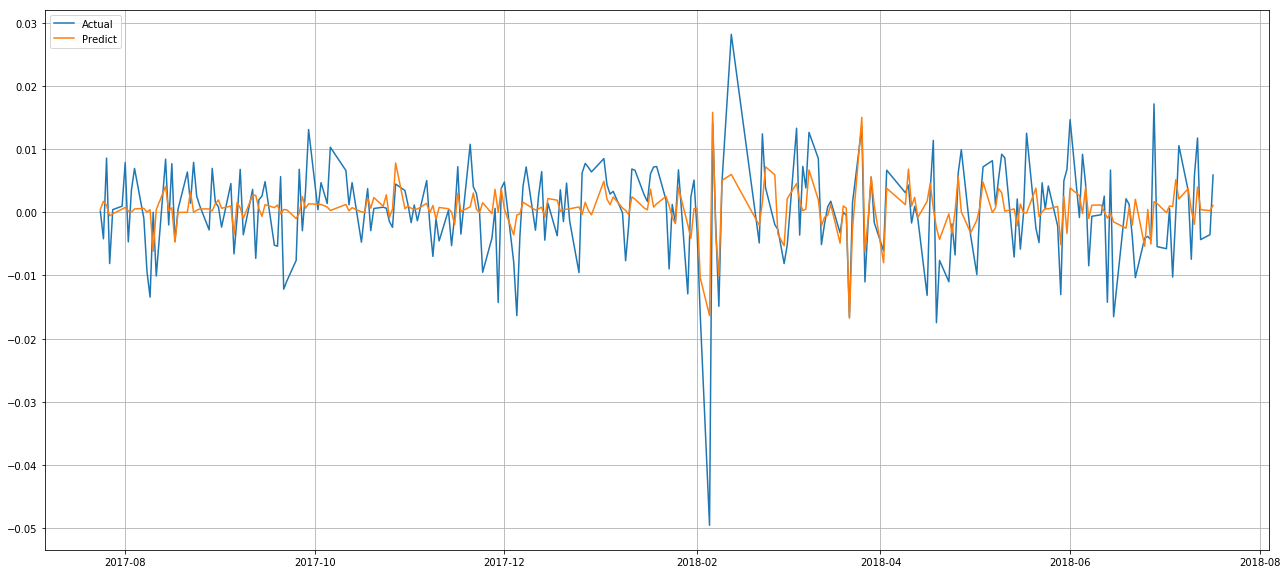

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(17, 15))
ax = fig.add_axes([0,0.2,1,0.5])
ax.plot(y_test, label='Actual')
ax.plot(y_pred, label='Predict')
ax.legend(loc='upper left')
ax.grid(True)
#ax.set_title('驗證預測漲跌幅',fontsize=24,color='b')

In [31]:
from sklearn import metrics
print("平均標準差MAE:%.4f"% metrics.mean_absolute_error(y_test, y_pred))
print("R2:%.2f"% metrics.r2_score(y_test, y_pred))

平均標準差MAE:0.0047
R2:0.31


回測模型收益

In [32]:
signal = (y_pred > 0)
df = pd.read_csv('datasets/^TWII-history.csv')
df.index = pd.to_datetime(df.Date)
y_verify = pd.DataFrame(df[y_pred.index[0]:signal.index[-1]]['Adj Close'])

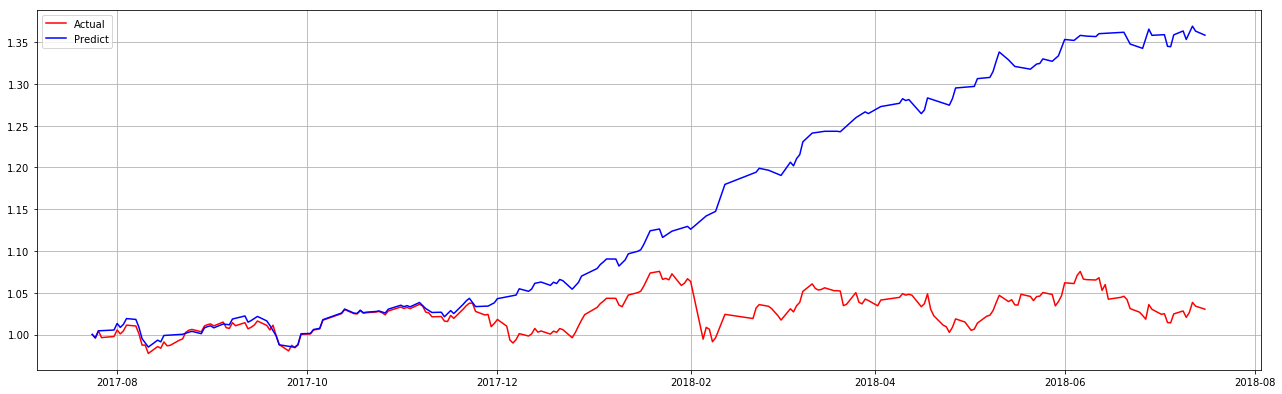

In [33]:
fig = plt.figure(figsize=(17, 10))
ax = fig.add_axes([0,0.2,1,0.5])
ax.plot((y_verify.shift(-1) / y_verify).cumprod(), label='Actual',color='red')
ax.plot((y_verify.shift(-1) / y_verify)[np.array(signal)].cumprod(), label='Predict',color='blue')
ax.legend(loc='upper left')
ax.grid(True)
#ax.set_title('回測模型收益率',fontsize=24,color='b')

In [34]:
gain_rate = (y_verify.shift(-1) / y_verify)[np.array(signal)].cumprod()
print('期末收益率：',str(round(((float(gain_rate.iloc[-2:-1,0])-1)*100),2)),'%')

期末收益率： 35.83 %


小結
====
**篩選變項對模型準確率影響不大，但是從2000年起至今的資料筆數僅有不到5000筆，減少變項對訓練的加速並不明顯，無需為此犧牲其他變相隱含的資訊。所以以下實測應用採用原本的模型來預測。**

<<實際預測明天漲跌幅>>
========

變項資料若無法自動下載可至以下連結手動下載：
1. https://finance.yahoo.com/quote/399001.SZ/history?period1=1531152000&period2=1532016000&interval=1d&filter=history&frequency=1d
2. https://cn.investing.com/indices/szse-component

即時從Yahoo Fainace抓取各變項指數：

In [125]:
import pandas as pd
import fix_yahoo_finance as yf
import datetime

begin_date = datetime.date.today() - datetime.timedelta(days=2)    #取昨天和今天，兩天才能計算漲跌幅
#深圳成指無法從yahoo finace下載
#para_array = ['^TWII', '^DJI', '^GSPC', '^IXIC', '^SOX', '^NYA', '^VIX', 'VGK', 'VT', '000001.SS', '399001.SZ', '^N225', 'FXI', 'BND', 'IEF', 'SHY', 'TLT', 'CL=F', 'GC=F', 'TWD=X']
para_array = ['^TWII', '^DJI', '^GSPC', '^IXIC', '^SOX', '^NYA', '^VIX', 'VGK', 'VT', '000001.SS', '^N225', 'FXI', 'BND', 'IEF', 'SHY', 'TLT', 'CL=F', 'GC=F', 'TWD=X']
#從Yahoo逐一讀取各變項資料
for para_code in para_array:
#    df = data.DataReader(para_code, "yahoo", begin_date,datetime.date.today())
    df = yf.download(para_code,begin_date,datetime.date.today())
    #清除空資料
    df = df.dropna()
    #存檔
    df.to_csv('datasets/'+para_code+'-'+begin_date.strftime("%Y%m%d")+'.csv')
    #取出收盤價與交易量 
    df_diff = df[['Adj Close', 'Volume']]
    #計算漲跌幅
    df_diff = df_diff.diff() / df_diff.shift(1)
    #存檔
    df_diff.to_csv('datasets/'+para_code+'-'+begin_date.strftime("%Y%m%d")+'-diff.csv')

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded


In [133]:
### 以下為手動下載資料後，將收盤價與成交量資料轉為漲跌幅
#para_code='399001.SZ'
#df = pd.read_csv('datasets/'+para_code+'-'+begin_date.strftime("%Y%m%d")+'.csv').replace(',','')
#df.index = pd.to_datetime(df.Date)
#清除空資料
#df = df.dropna()
#取出收盤價與交易量 
#df_diff = df[['Adj Close', 'Volume']].convert_objects(convert_numeric=True).dtypes
#計算漲跌幅
#df_diff = df_diff.diff() / df_diff.shift(1)
#存檔
#df_diff.to_csv('datasets/'+para_code+'-'+begin_date.strftime("%Y%m%d")+'-diff.csv')

將收盤價與成交量資料轉為漲跌幅：

In [160]:
para_array = ['^TWII', '^DJI', '^GSPC', '^IXIC', '^SOX', '^NYA', '^VIX', 'VGK', 'VT', '000001.SS', '399001.SZ', '^N225', 'FXI', 'BND', 'IEF', 'SHY', 'TLT', 'CL=F', 'GC=F', 'TWD=X']
#從檔案逐一讀取各變項資料，合併成大表
df_type_array = ['.csv','-diff.csv']
for df_type in df_type_array:
    df_all = pd.read_csv('datasets/^TWII-'+begin_date.strftime("%Y%m%d")+df_type)
    df_all.index = pd.to_datetime(df_all.Date)
    df_all = df_all.drop(columns=['Date'])
    df_all.columns = df_all.columns+'-^TWII'    
    for para_code in para_array[1:]:
        df = pd.read_csv('datasets/'+para_code+'-'+begin_date.strftime("%Y%m%d")+df_type)
        df.index = pd.to_datetime(df.Date)
        df = df.drop(columns=['Date'])
        df.columns = df.columns+'-'+para_code
        df_all = pd.concat([df_all, df], axis=1, join_axes=[df_all.index])
    df_all.to_csv('datasets/df_all-'+begin_date.strftime("%Y%m%d")+df_type)

今日各變項指數漲跌幅如下：

In [161]:
df_all

,Adj Close-^TWII,Volume-^TWII,Adj Close-^DJI,Volume-^DJI,Adj Close-^GSPC,Volume-^GSPC,Adj Close-^IXIC,Volume-^IXIC,Adj Close-^SOX,Volume-^SOX,...,Adj Close-SHY,Volume-SHY,Adj Close-TLT,Volume-TLT,Adj Close-CL=F,Volume-CL=F,Adj Close-GC=F,Volume-GC=F,Adj Close-TWD=X,Volume-TWD=X
Date,,,,,,,,,,,,,,,,,,,,,
2018-07-18,NaN,NaN,0.003161,0.009663,0.002161,0.01280,-0.000087,0.067209,0.007704,NaN,...,-0.000120,-0.656327,-0.004017,0.681588,0.017267,-0.623093,-0.000489,0.042619,0.00246,NaN
2018-07-19,-0.000653,-0.140619,-0.005349,0.130067,-0.003953,0.05726,-0.003710,-0.002498,-0.002658,NaN,...,0.000481,0.218442,0.006338,-0.025798,0.011026,-0.688051,-0.003748,0.303540,NaN,NaN


In [171]:
#清理資料，挑選要用的特徵變項
df_all_diff = df_all.fillna(0).replace(np.inf, 0).replace(-np.inf, 0)
df_all_diff_columns = pd.read_csv('model_columns.csv')
df_all_diff = df_all_diff[df_all_diff_columns['0']]
X_today = df_all_diff[-1:]

運用訓練好的模型進行預測

In [173]:
from sklearn.externals import joblib

gb_r = joblib.load("GradientBoostingRegressor.pkl")  # 將預存訓練好的模型pkl檔載入用來預測
y_next = gb_r.predict(X_today)

In [177]:
print('預測明天台股指數漲跌幅為：',str(round(y_next[0]*100,2)),'%')

預測明天台股指數漲跌幅為： 0.03 %
